### Required Libraries

In [14]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.neighbors import KernelDensity
from scipy.integrate import cumulative_trapezoid
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from sklearn.cluster import DBSCAN
import seaborn as sns
import itertools



In [15]:
models_dir = '/Applications/UNI/Thesis/saved_kde'
os.makedirs(models_dir, exist_ok=True) 


### Data

European Social Survey European Research Infrastructure (ESS ERIC). (2023). ESS8 - integrated file, edition 2.3 [Data set]. Sikt - Norwegian Agency for Shared Services in Education and Research. https://doi.org/10.21338/ess8e02_3

Data collection period: 01-09-2016 - 31-01-2017




In [16]:

# Load your data
df = pd.read_csv('/Applications/UNI/Thesis/datasets/ESS8e02_3.csv')

# Filter the DataFrame for rows where 'cntry' is 'NL'
netherlands_df = df[df['cntry'] == 'NL']


/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_97495/1230602784.py:2: DtypeWarning: Columns (168) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Applications/UNI/Thesis/datasets/ESS8e02_3.csv')


In [39]:
netherlands_df

,name,essround,edition,proddate,idno,cntry,dweight,pspwght,pweight,anweight,...,inwmms,inwyys,inwshh,inwsmm,inwdde,inwmme,inwyye,inwehh,inwemm,inwtm
32909,ESS8e02_3,8,2.3,23.11.2023,11310081,NL,1.012680,1.047340,0.843507,0.883439,...,1,2017,17,0,27,1,2017,18,32,92.0
32910,ESS8e02_3,8,2.3,23.11.2023,11310110,NL,0.506340,0.586621,0.843507,0.494819,...,11,2016,13,56,17,11,2016,14,58,62.0
32911,ESS8e02_3,8,2.3,23.11.2023,11310165,NL,0.506340,0.434278,0.843507,0.366316,...,10,2016,10,0,11,10,2016,19,15,555.0
32912,ESS8e02_3,8,2.3,23.11.2023,11310169,NL,2.025359,2.346485,0.843507,1.979276,...,11,2016,13,36,25,11,2016,14,49,73.0
32913,ESS8e02_3,8,2.3,23.11.2023,11310171,NL,0.506340,0.739326,0.843507,0.623627,...,11,2016,13,12,22,11,2016,14,33,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34585,ESS8e02_3,8,2.3,23.11.2023,61430929,NL,0.506340,0.564168,0.843507,0.475879,...,11,2016,10,49,14,11,2016,12,11,82.0
34586,ESS8e02_3,8,2.3,23.11.2023,61431750,NL,1.012680,1.033918,0.843507,0.872116,...,11,2016,19,38,16,11,2016,20,55,77.0
34587,ESS8e02_3,8,2.3,23.11.2023,61432247,NL,1.012680,1.033918,0.843507,0.872116,...,11,2016,13,43,15,11,2016,14,43,60.0
34588,ESS8e02_3,8,2.3,23.11.2023,61432846,NL,1.012680,1.158207,0.843507,0.976955,...,1,2017,9,30,19,1,2017,10,49,79.0


### Function to process KDE, save fitted model and plot

In [18]:
def process_kde(column, valid_range, models_dir, reverse_scale=False, max_value=None):
    # Filter and process the data for the column
    valid_df = netherlands_df[netherlands_df[column].isin(valid_range)].copy()
    valid_df[column] = valid_df[column].astype(float)

    if reverse_scale:
        # Reverse the scale
        valid_df[column] = (max_value + 1) - valid_df[column]

    # Normalize to 0-1 scale
    valid_df[column] = valid_df[column] / max_value

    # Ensure data is within [0, 1] before fitting KDE
    valid_df[column] = np.clip(valid_df[column], 0, 1)

    # Setup the grid search with Leave-One-Out cross-validation
    bandwidths = 10 ** np.linspace(-1, 1, 100)
    grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, cv=LeaveOneOut())
    grid.fit(valid_df[column].values.reshape(-1, 1))

    # Find the optimal bandwidth
    best_bandwidth = grid.best_params_['bandwidth']
    print(f"Best bandwidth for {column}: ", best_bandwidth)

    # Fit and plot KDE with the best bandwidth
    kde = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth)
    kde.fit(valid_df[column].values.reshape(-1, 1))

    model_path = os.path.join(models_dir, f'kde_{column}.pkl')
    
    # Save the fitted model
    joblib.dump(kde, model_path)

    # Create an array of values for plotting the KDE
    x_d = np.linspace(0, 1, 1000).reshape(-1, 1)
    logprob = kde.score_samples(x_d)

    pdf = np.exp(logprob)
    cdf = cumulative_trapezoid(pdf, x_d[:, 0], initial=0)

    # Plot the KDE
    plt.fill_between(x_d[:, 0], np.exp(logprob), alpha=0.5)
    plt.plot(valid_df[column].values, np.full_like(valid_df[column].values, -0.01), '|k', markeredgewidth=1)
    plt.title(f'KDE of {column}')
    plt.show()

    # Plot the CDF
    plt.plot(x_d[:, 0], cdf, label='CDF')
    plt.title(f'CDF of {column}')
    plt.xlabel('Value')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.show()

    # Save the CDF and corresponding x values
    cdf_path = os.path.join(models_dir, f'cdf_{column}.pkl')
    joblib.dump((x_d[:, 0], cdf), cdf_path)

    return x_d[:, 0], pdf




### ccrdprs - To what extent feel personal responsibility to reduce climate change

Best bandwidth for ccrdprs:  0.1


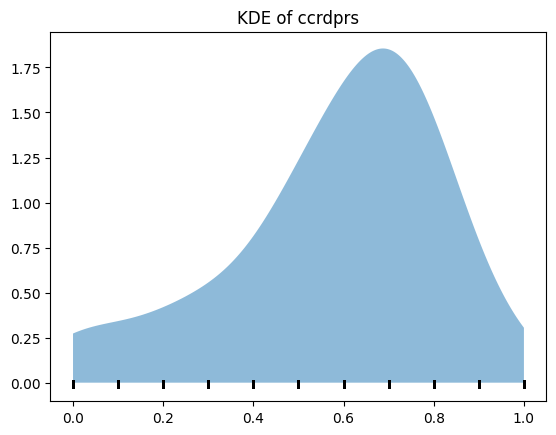

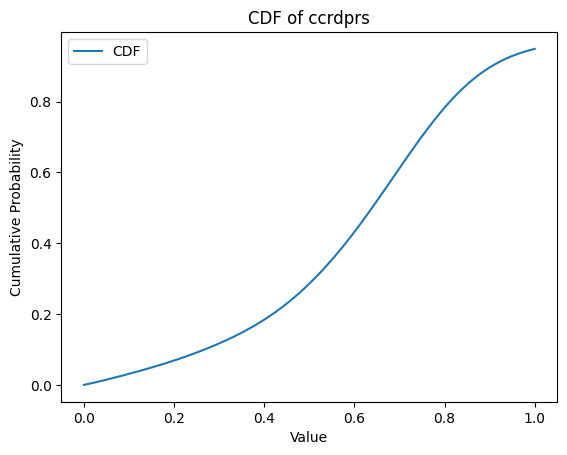

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [21]:
process_kde('ccrdprs', range(11), models_dir, False, 10)

### lkredcc - Imagine large numbers of people limit energy use, how likely reduce climate change.

Best bandwidth for lkredcc:  0.1


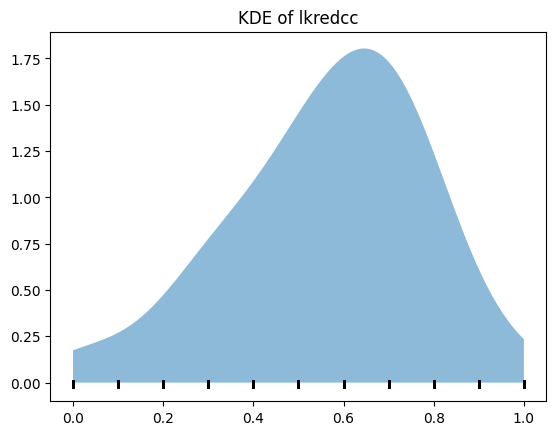

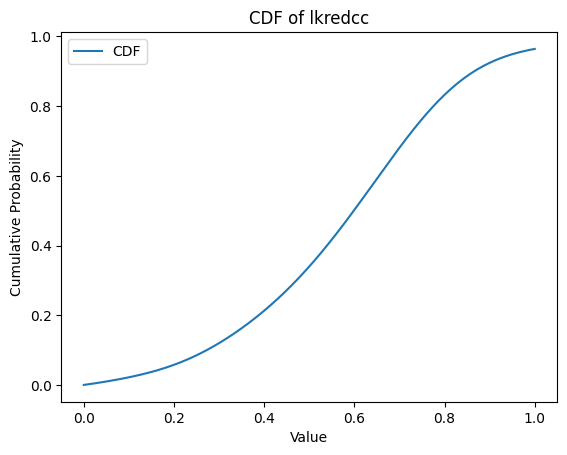

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [22]:
process_kde('lkredcc', range(11), models_dir, False, 10)

### wrclmch - How worried about climate change

Best bandwidth for wrclmch:  0.1


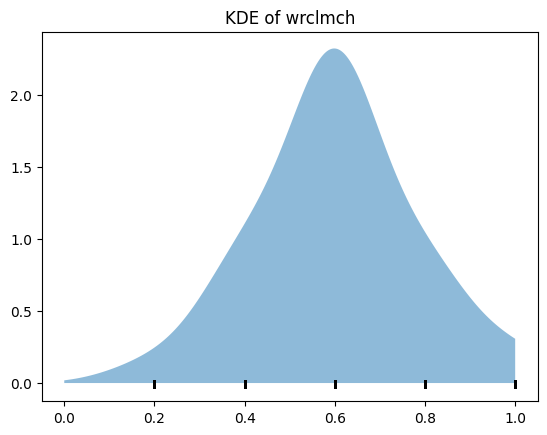

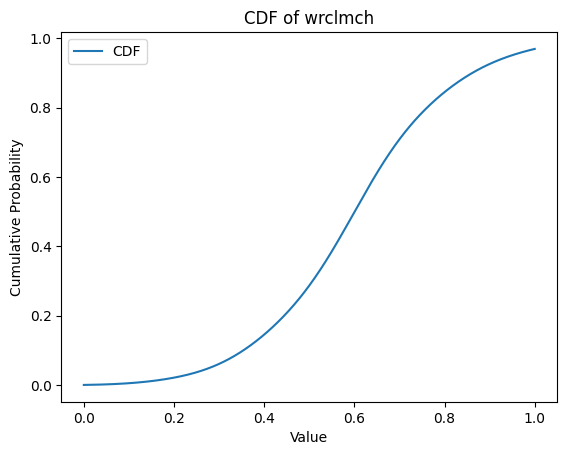

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [23]:
process_kde('wrclmch', range(6), models_dir, False, 5)


### gvsrdcc - How likely, governments in enough countries take action to reduce climate change

Best bandwidth for gvsrdcc:  0.1


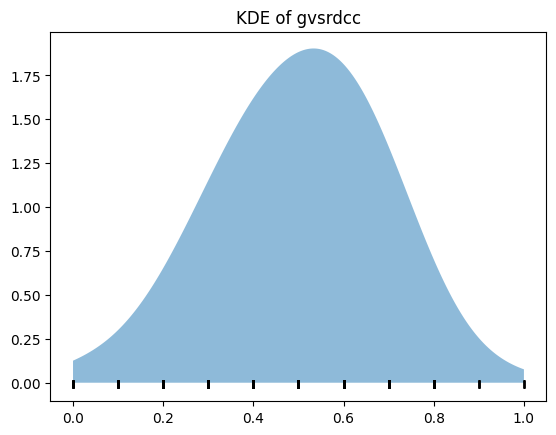

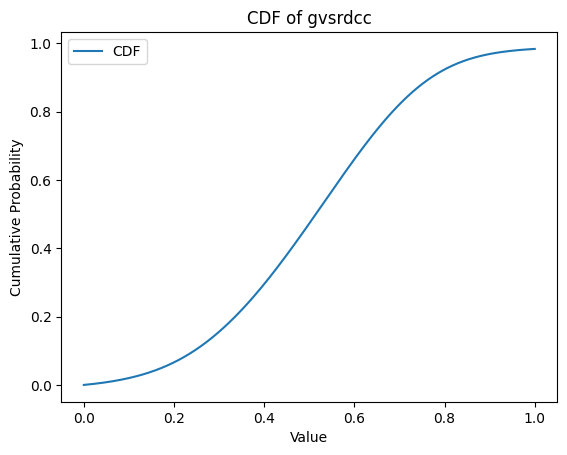

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [24]:
process_kde('gvsrdcc', range(11), models_dir, False, 10)


### inctxff - Favour increase taxes on fossil fuels to reduce climate change

Best bandwidth for inctxff:  0.1


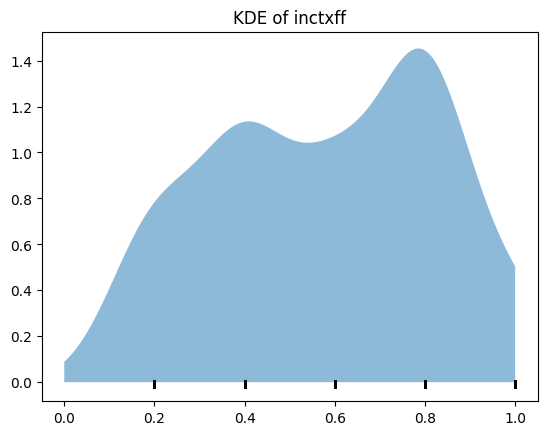

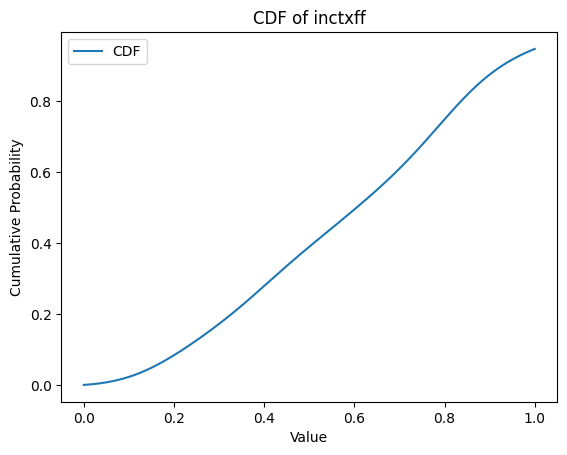

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [25]:
process_kde('inctxff', range(6), models_dir, True, 5)


### sbsrnen - Favour subsidise renewable energy to reduce climate change


Best bandwidth for sbsrnen:  0.1


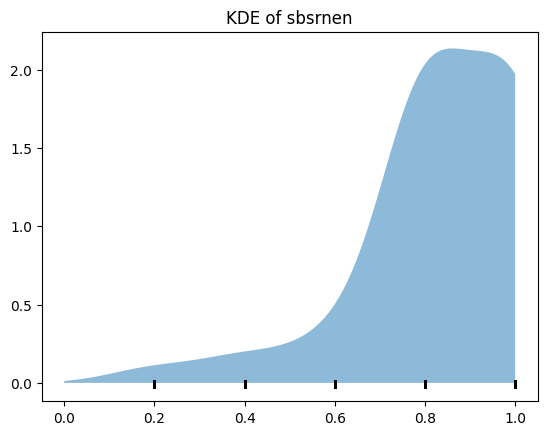

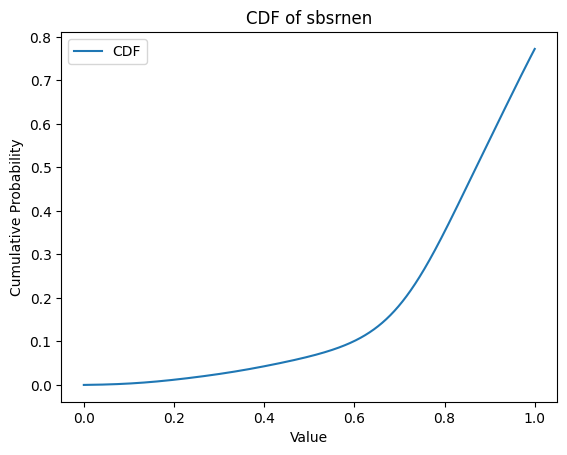

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [26]:
process_kde('sbsrnen', range(6), models_dir, True, 5)


### iplylfr - Important to be loyal to friends and devote to people close



Best bandwidth for iplylfr:  0.1


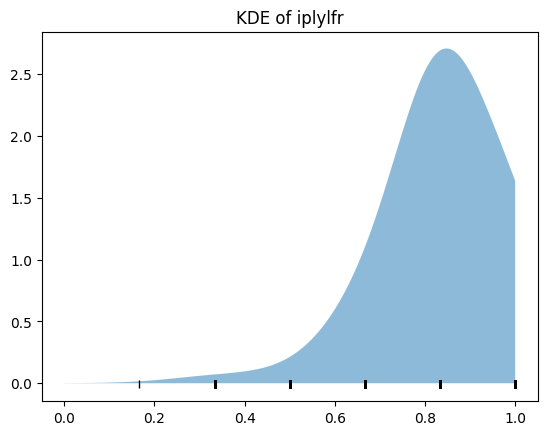

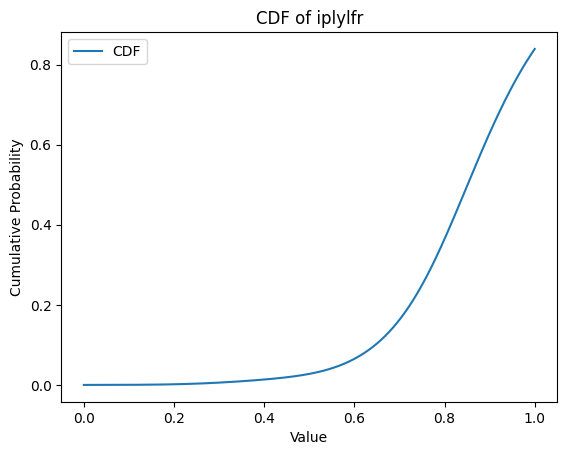

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [27]:
process_kde('iplylfr', range(7), models_dir, True, 6)


### Social Meet

Best bandwidth for sclmeet:  0.1


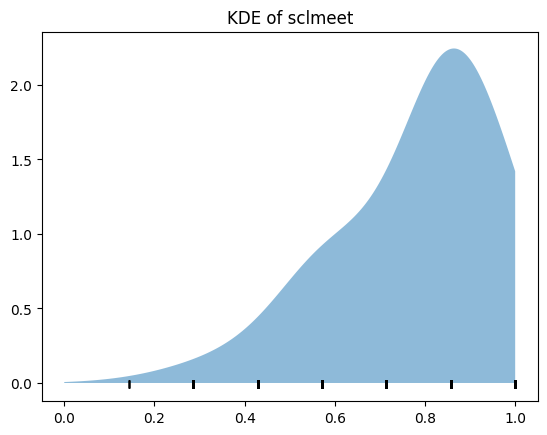

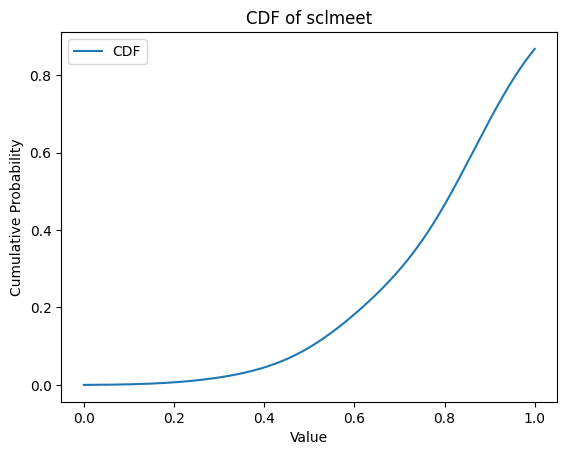

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [28]:
process_kde('sclmeet', range(8), models_dir, False, 7)


### Discuss intimate and personal matters?

Best bandwidth for inprdsc:  0.1


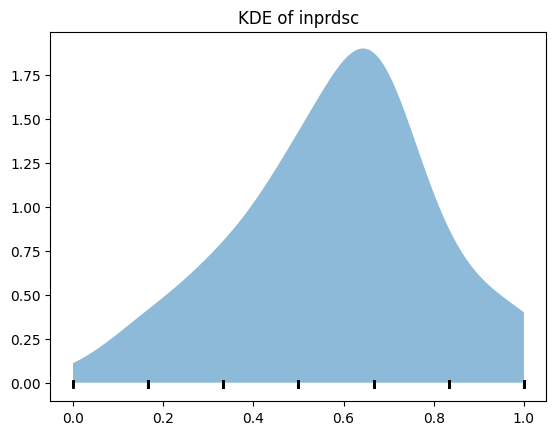

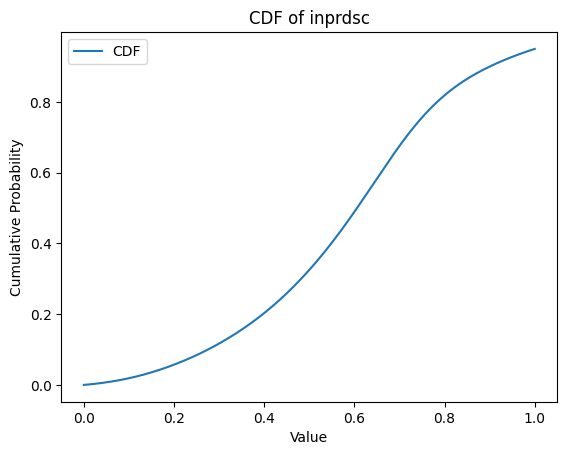

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [29]:
process_kde('inprdsc', range(7), models_dir, False, 6)


### wrkctra -  Employment contract unlimited or limited duration

Best bandwidth for wrkctra:  0.1


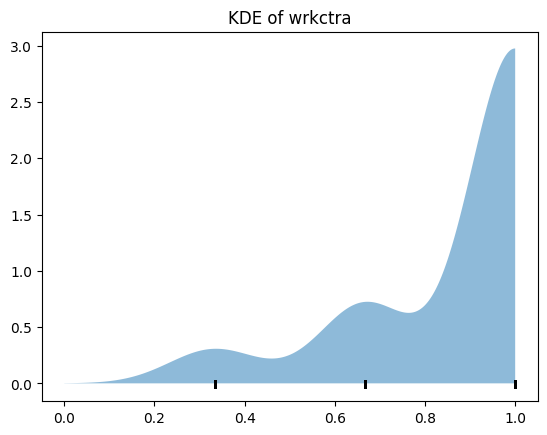

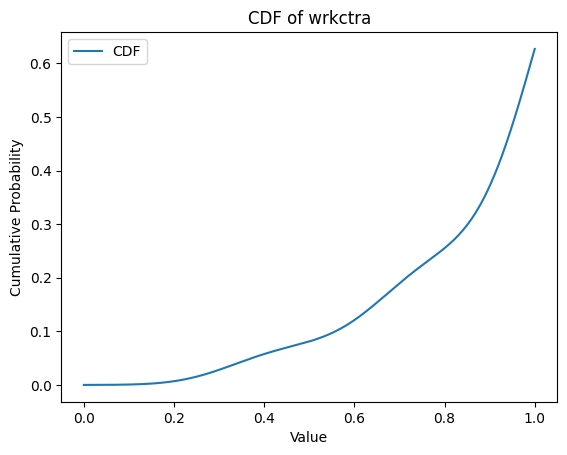

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [30]:
process_kde('wrkctra', range(4), models_dir, True, 3)


### hincfel - Feeling household income

1	Living comfortably on present income

2	Coping on present income

3	Difficult on present income

4	Very difficult on present income

Best bandwidth for hincfel:  0.1


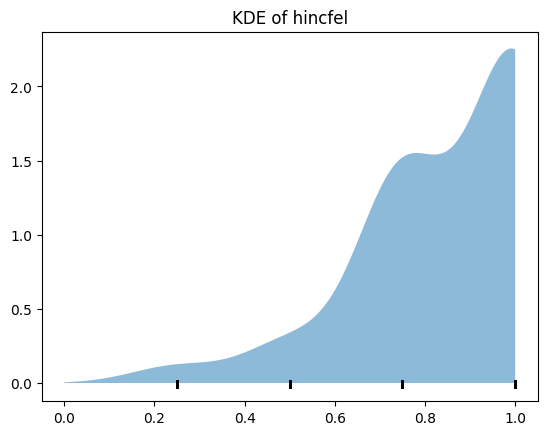

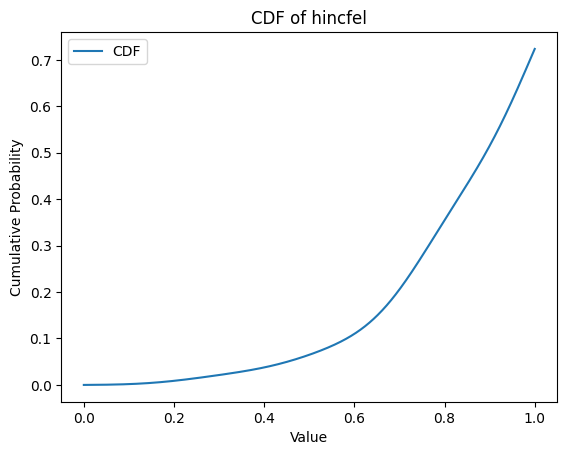

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [31]:
process_kde('hincfel', range(5), models_dir, True, 4)


### imprich - Important to be rich, have money and expensive things

Best bandwidth for imprich:  0.1


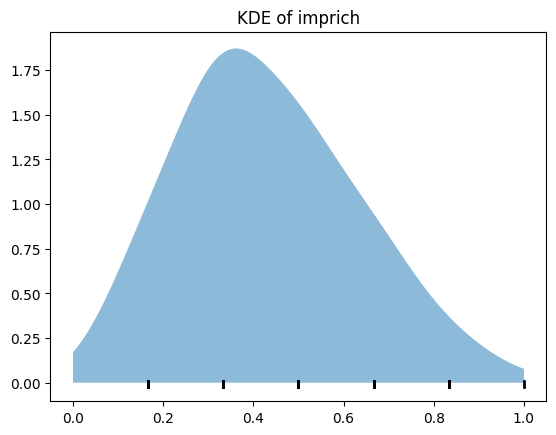

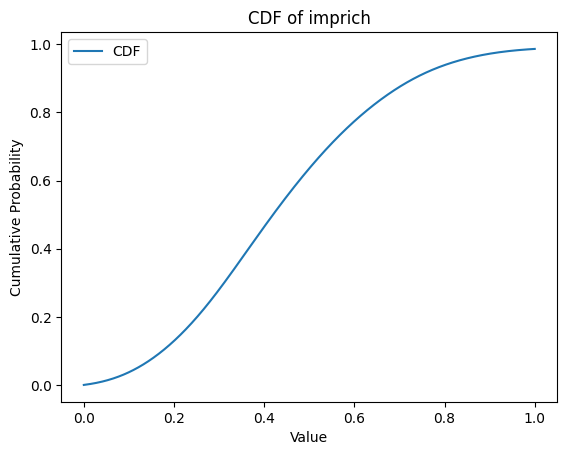

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [32]:
process_kde('imprich', range(7), models_dir, True, 6)


### impenv - Important to care for nature and environment

Best bandwidth for impenv:  0.1


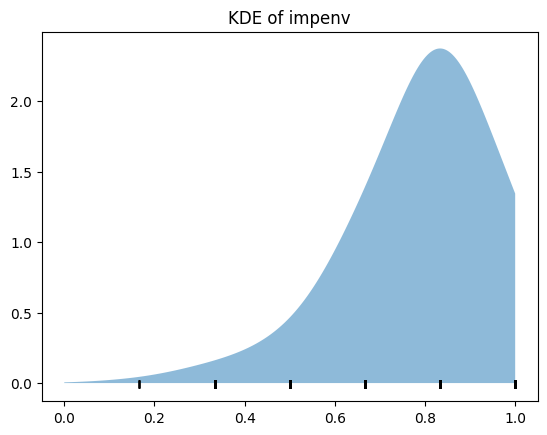

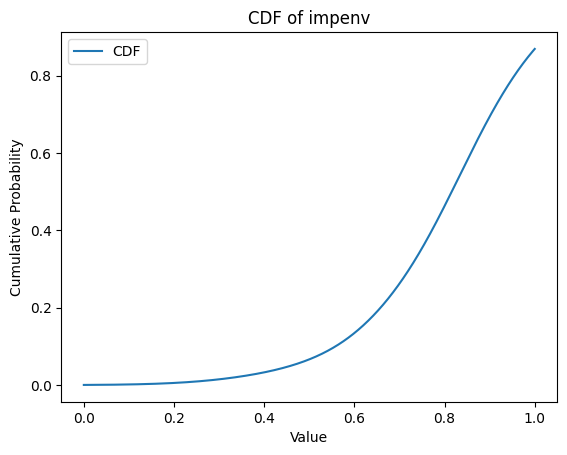

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [33]:
process_kde('impenv', range(7), models_dir, True, 6)


### impfree - Important to make own decisions and be free

Best bandwidth for impfree:  0.1


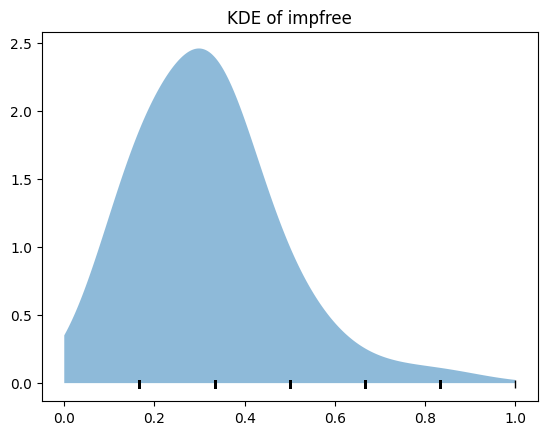

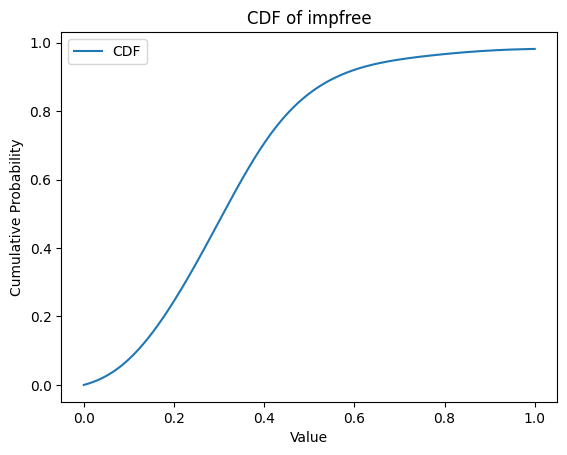

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [34]:
process_kde('impfree', range(7), models_dir, False, 6)


### ipfrule - Important to do what is told and follow rules

Best bandwidth for ipfrule:  0.1


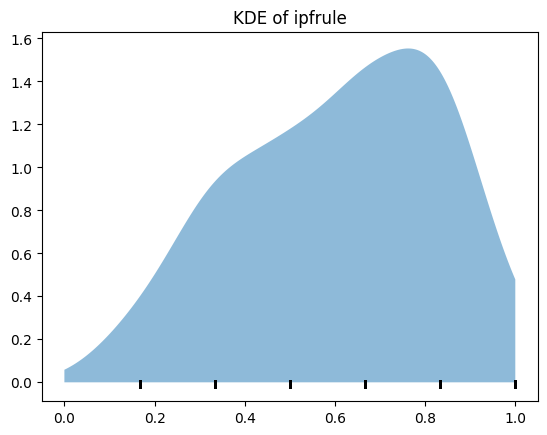

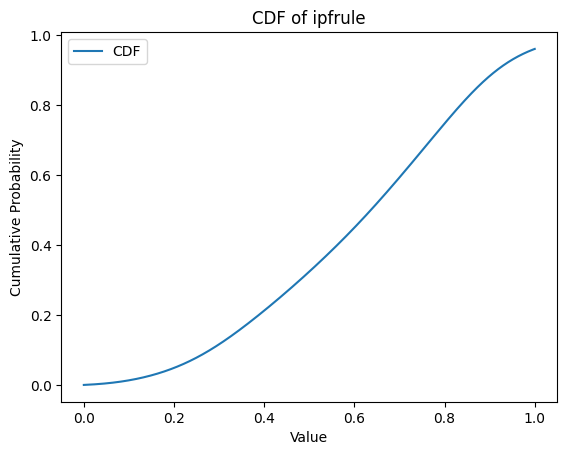

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [35]:
process_kde('ipfrule', range(7), models_dir, True, 6)

### eneffap - How likely to buy most energy efficient home appliance

Best bandwidth for eneffap:  0.1


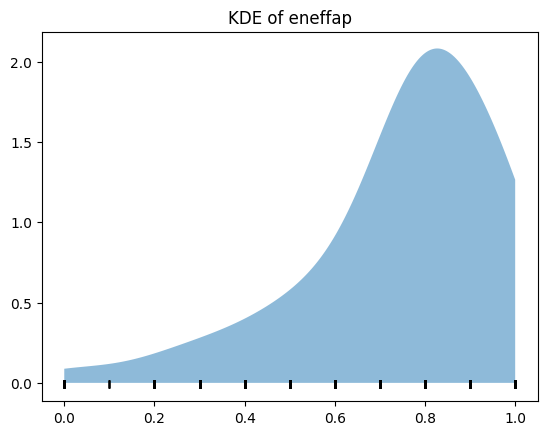

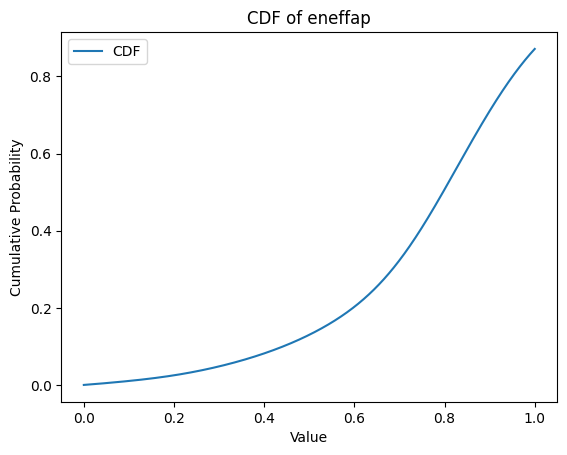

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [36]:
process_kde('eneffap', range(11), models_dir, False, 10)

### wrenexp - How worried, energy too expensive for many people

Best bandwidth for wrenexp:  0.1


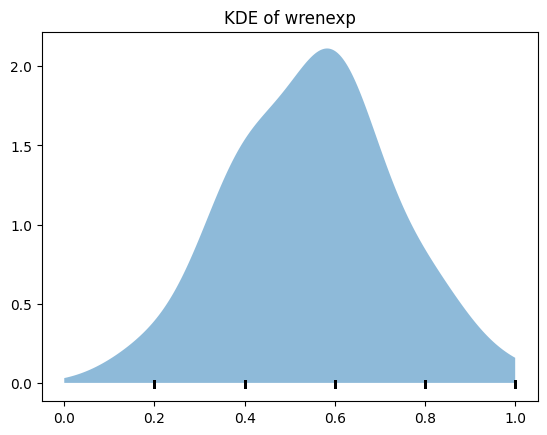

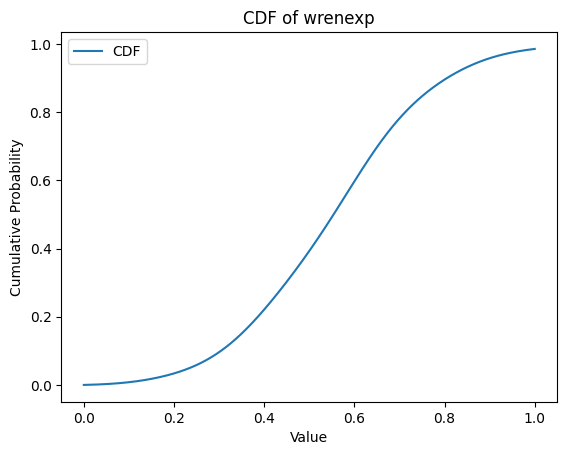

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [37]:
process_kde('wrenexp', range(6), models_dir, False, 5)

Best bandwidth for mnactic:  0.1


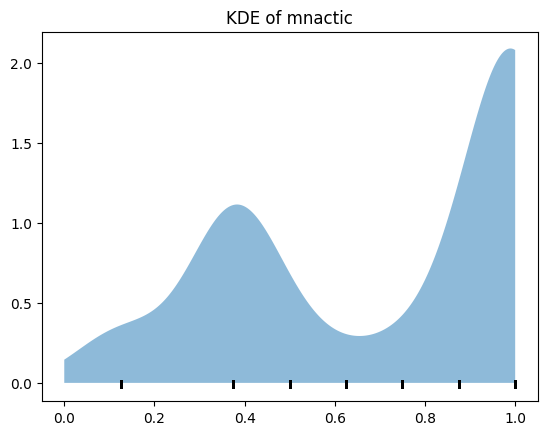

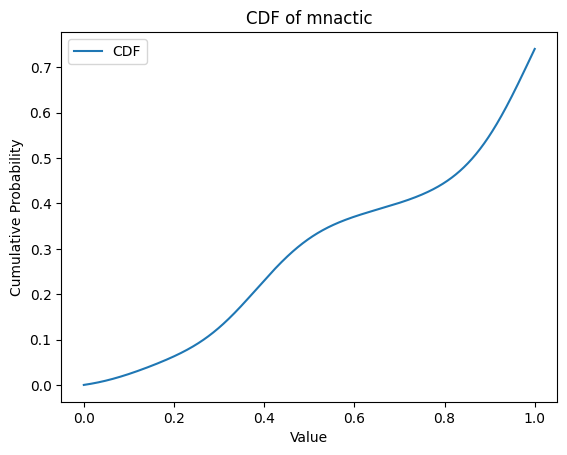

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [38]:
process_kde('mnactic', range(9), models_dir, True, 8)

# **How to use all of this data?**

## All Climate Change Data

'eneffap', 'rdcenr', 'cflsenr', 'elgcoal', 'elgngas', 'elghydr', 'elgnuc', 'elgsun', 
                     'elgwind', 'elgbio', 'wrpwrct', 'wrenexp', 'wrdpimp', 'wrdpfos', 'wrntdis', 
                     'wrinspw', 'wrtcfl', 'wrtratc', 'clmchng', 'clmthgt1', 'clmthgt2', 'ccnthum', 
                     'ccrdprs', 'wrclmch', 'ccgdbd', 'lkredcc', 'lklmten', 'gvsrdcc', 'ownrdcc', 
                     'inctxff', 'sbsrnen', 'banhhap'

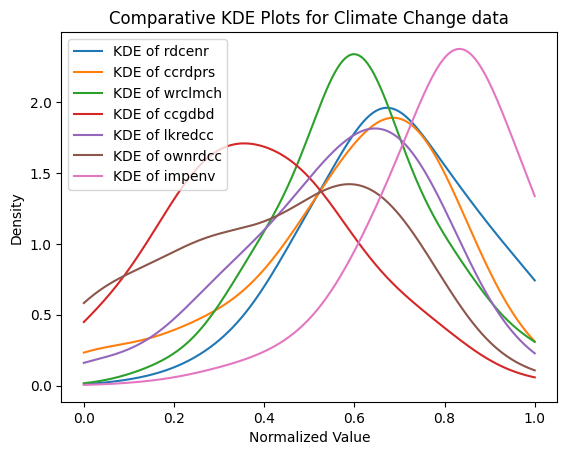

         rdcenr  ccrdprs  wrclmch  ccgdbd  lkredcc  ownrdcc    impenv
32909  0.833333      0.8      0.8     0.1      0.9      0.3  0.833333
32910  0.500000      0.5      0.6     0.6      0.7      0.6  0.833333
32912  0.833333      0.5      0.6     0.3      0.8      0.8  0.666667
32913  1.000000      0.7      0.6     0.3      0.5      0.0  0.833333
32914  0.833333      0.7      0.6     0.6      0.7      0.6  0.833333
...         ...      ...      ...     ...      ...      ...       ...
34585  0.666667      0.5      0.8     0.0      0.8      0.5  0.833333
34586  0.500000      0.7      0.6     0.4      0.6      0.6  0.833333
34587  0.500000      0.2      0.6     0.2      0.2      0.2  0.500000
34588  0.666667      0.6      0.6     0.4      0.7      0.6  0.666667
34589  1.000000      0.2      0.6     0.3      0.3      0.2  0.833333

[1578 rows x 7 columns]
Cronbach's Alpha: 0.5731175368772905


In [24]:
# Define the variables for each category
climate_change_vars = [ 'rdcenr','ccrdprs', 'wrclmch', 'ccgdbd', 'lkredcc', 'ownrdcc', 'impenv']

# Creating a specific DataFrame for Climate Change
climate_change_data = netherlands_df[climate_change_vars].copy()


non_believer_responses = {
    'ccnthum': 1,
    'ccrdprs': 0,
    'wrclmch': 1,
    'ccgdbd': 5,  # or choose a neutral point like 5 if neutral perception is assumed
    'lkredcc': 0,
    'lklmten': 0,
    'gvsrdcc': 0,
    'ownrdcc': 0
}

valid_range_dict = {
    'eneffap': range(0, 11),
    'rdcenr': range(1, 7),
    'wrenexp': range(1, 6),
    'wrdpfos': range(1, 6),
    'ccnthum': range(1, 6),
    'ccrdprs': range(0, 11),
    'wrclmch': range(1, 6),
    'ccgdbd': range(0, 11),
    'lkredcc': range(0, 11),
    'lklmten': range(0, 11),
    'gvsrdcc': range(0, 11),
    'ownrdcc': range(0, 11),
    'inctxff': range(1, 6),
    'sbsrnen': range(1, 6),
    'banhhap': range(1, 6),
    'impenv': range(1,7),
    'clmchng': range(1,5)
}


reverse_scale_dict = {
    'eneffap': False, 'rdcenr': False, 
 'wrenexp': False,
     'wrdpfos': False,
    'ccnthum': False, 'ccrdprs': False, 'wrclmch': False,
    'ccgdbd': False, 'lkredcc': False, 'lklmten': False,
    'gvsrdcc': False, 'ownrdcc': False, 'inctxff': True,
    'sbsrnen': True, 'banhhap': True, 'impenv': True, 'clmchng': True
}


max_value_dict = {
    'eneffap': 10, 'rdcenr': 6, 'wrenexp': 5,
     'wrdpfos': 5, 
    'ccnthum': 5, 'ccrdprs': 10, 'wrclmch': 5,
    'ccgdbd': 10, 'lkredcc': 10, 'lklmten': 10,
    'gvsrdcc': 10, 'ownrdcc': 10, 'inctxff': 5,
    'sbsrnen': 5, 'banhhap': 5, 'impenv': 6, 'clmchng': 4
}

climate_change_vars2 = [ 'rdcenr','ccrdprs', 'wrclmch', 'ccgdbd', 'lkredcc', 'ownrdcc', 'impenv']


def preprocess_data(df, column, reverse_scale, max_value):
    if reverse_scale:
        df[column] = (max_value + 1) - df[column]
    df[column] /= max_value

# Define directories and ensure they exist
models_dir = 'saved_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Function to plot KDE and save model
def simplified_kde_plot(column, df):
    # Make sure the data is a float and drop any NaNs that could disrupt KDE
    valid_df = df[[column]].dropna().astype(float)

    # Fit KDE and save the model
    kde = KernelDensity(kernel='gaussian', bandwidth=0.1)
    kde.fit(valid_df.values.reshape(-1, 1))
    model_path = os.path.join(models_dir, f'kde_{column}.pkl')
    joblib.dump(kde, model_path)

    # Plotting KDE
    x_d = np.linspace(0, 1, 1000).reshape(-1, 1)
    logprob = kde.score_samples(x_d)
    pdf = np.exp(logprob)
    plt.plot(x_d, pdf, label=f'KDE of {column}')

# Function to calculate Cronbach's Alpha
def cronbach_alpha(df):
    item_variances = df.var(axis=0, ddof=1)
    total_variance = df.sum(axis=1).var(ddof=1)
    n_items = len(df.columns)
    return (n_items / (n_items - 1)) * (1 - item_variances.sum() / total_variance)


# Preprocessing data
for column in climate_change_vars2:
    original_count = climate_change_data.shape[0]
    climate_change_data = climate_change_data[climate_change_data[column].isin(valid_range_dict[column])]
    filtered_count = climate_change_data.shape[0]
   #print(f"{column}: Reduced from {original_count} to {filtered_count}")
    preprocess_data(climate_change_data, column, reverse_scale_dict[column], max_value_dict[column])


# Plotting KDE for each variable
for column in climate_change_vars2:
    simplified_kde_plot(column, climate_change_data)

plt.title('Comparative KDE Plots for Climate Change data')
plt.xlabel('Normalized Value')
plt.ylabel('Density')
plt.legend()
plt.show()

print(climate_change_data)
# Calculate and print Cronbach's Alpha
alpha = cronbach_alpha(climate_change_data)  # Ensure no NaNs before calculating
print(f"Cronbach's Alpha: {alpha}")

/Users/isabelklennert/opt/anaconda3/envs/thesisenv/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/isabelklennert/opt/anaconda3/envs/thesisenv/lib/python3.9/site-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


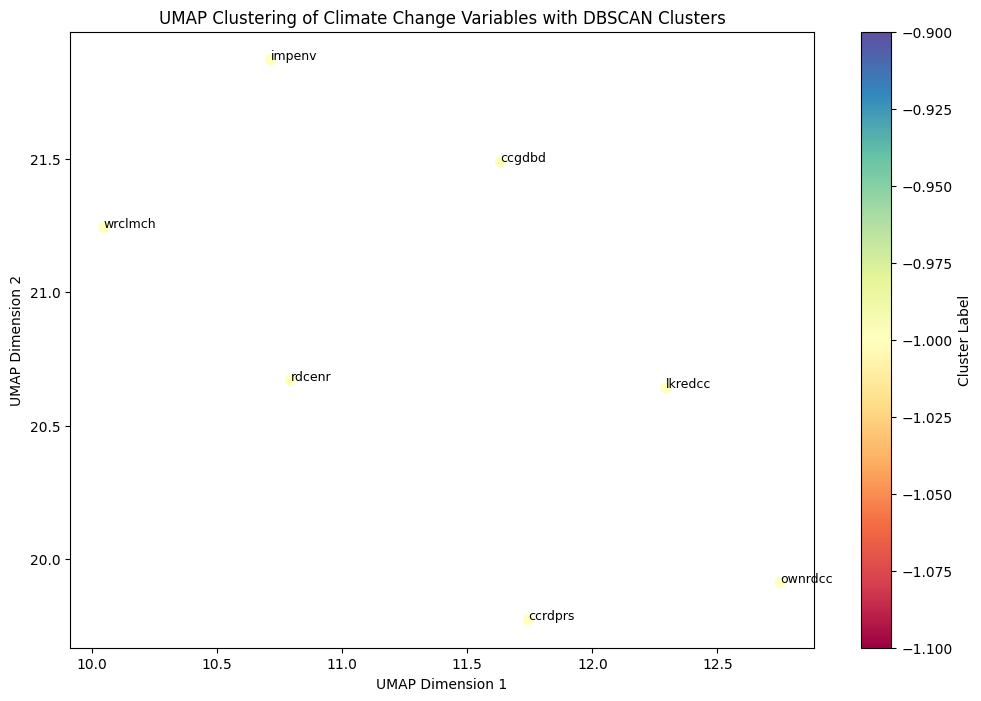

Cluster -1: ['rdcenr', 'ccrdprs', 'wrclmch', 'ccgdbd', 'lkredcc', 'ownrdcc', 'impenv']
Cronbach's Alpha for Cluster -1: 0.6485311112830524


In [36]:

# Ensure you have the climate_change_data with appropriate preprocessing
climate_change_vars2 = [ 'rdcenr','ccrdprs', 'wrclmch', 'ccgdbd', 'lkredcc', 'ownrdcc', 'impenv']

# Preprocess the data once
data_to_scale = climate_change_data[climate_change_vars2].dropna(axis=1).transpose()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Define the function to perform UMAP clustering
def umap_clustering(scaled_data, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', random_state=42):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric=metric, random_state=random_state)
    embedding = reducer.fit_transform(scaled_data)
    return embedding

# Visualize UMAP Clusters
def plot_umap(embedding, data, title='UMAP Clustering of Climate Change Variables'):
    plt.figure(figsize=(12, 8))
    plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=50)
    
    for i, var in enumerate(data.index):
        plt.text(embedding[i, 0], embedding[i, 1], var, fontsize=9)
    
    plt.title(title)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.show()

# Apply UMAP Clustering with fixed random seed
embedding = umap_clustering(scaled_data, n_neighbors=20, min_dist=0.2, metric='cosine', random_state=42)

# Plot the UMAP Clusters
#plot_umap(embedding, data_to_scale)

# Apply DBSCAN to find clusters on the variable embeddings
clustering = DBSCAN(eps=0.5, min_samples=2).fit(embedding)

# Add cluster labels to the variable embeddings
cluster_labels = clustering.labels_

# Plot UMAP Clusters with DBSCAN clusters
plt.figure(figsize=(12, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='Spectral', s=50)
for i, var in enumerate(data_to_scale.index):
    plt.text(embedding[i, 0], embedding[i, 1], var, fontsize=9)
plt.title('UMAP Clustering of Climate Change Variables with DBSCAN Clusters')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Print cluster members
clusters = {}
for cluster in set(cluster_labels):
    clusters[cluster] = data_to_scale.index[cluster_labels == cluster].tolist()
    print(f"Cluster {cluster}: {clusters[cluster]}")

# Function to calculate Cronbach's Alpha
def cronbach_alpha(df):
    item_variances = df.var(axis=0, ddof=1)
    total_variance = df.sum(axis=1).var(ddof=1)
    n_items = len(df.columns)
    return (n_items / (n_items - 1)) * (1 - item_variances.sum() / total_variance)

# Calculate and print Cronbach's Alpha for each cluster
for cluster, variables in clusters.items():
    if variables:
        alpha = cronbach_alpha(climate_change_data[variables].dropna())
        print(f"Cronbach's Alpha for Cluster {cluster}: {alpha}")



Explained variance ratio: [0.34854844 0.18226902]
Total explained variance by the first two components: 0.5308174584035978
              PC1       PC2
ccgdbd   0.405236          
ccrdprs  0.499874          
impenv             0.704928
lkredcc  0.491232          
ownrdcc  0.502446          
wrclmch           -0.578647


/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_99024/2526527844.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  high_loading_vars.fillna("", inplace=True)  # Fill NaN values with empty string for better visualization


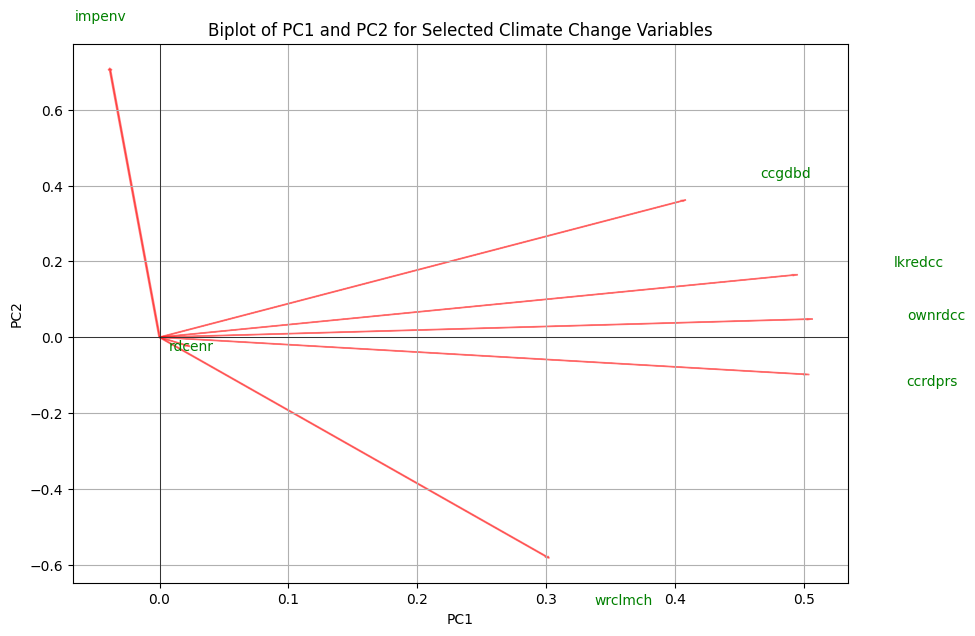

In [50]:


# Define the relevant variables
climate_change_vars =  [ 'rdcenr','ccrdprs', 'wrclmch', 'ccgdbd', 'lkredcc', 'ownrdcc', 'impenv']

# Creating a specific DataFrame for Climate Change
climate_change_data = netherlands_df[climate_change_vars].copy()

# Preprocess the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(climate_change_data)

# Perform PCA
pca = PCA(n_components=2)  # Adjust the number of components based on your needs
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame to display principal components more clearly
principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(2)])

# Loadings of the variables on each principal component
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(2)], index=climate_change_data.columns)

# Print explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance by the first two components:", sum(pca.explained_variance_ratio_))

# Set a threshold and select variables with high loadings
threshold = 0.4

high_loading_vars_pc1 = loadings.index[loadings['PC1'].abs() >= threshold].tolist()
high_loading_vars_pc2 = loadings.index[loadings['PC2'].abs() >= threshold].tolist()

selected_vars_pc1 = loadings[loadings['PC1'].abs() >= threshold][['PC1']].copy()
selected_vars_pc2 = loadings[loadings['PC2'].abs() >= threshold][['PC2']].copy()

# Merge the two DataFrames for better visualization
high_loading_vars = selected_vars_pc1.merge(selected_vars_pc2, how='outer', left_index=True, right_index=True)

# Display the table
high_loading_vars.fillna("", inplace=True)  # Fill NaN values with empty string for better visualization
print(high_loading_vars)

# Create a biplot
plt.figure(figsize=(10, 7))
origin = [0, 0]  # origin point

# Plot loadings
for i, (comp1, comp2) in enumerate(loadings.values):
    plt.arrow(origin[0], origin[1], comp1, comp2, color='r', alpha=0.5)
    plt.text(comp1 * 1.2, comp2 * 1.2, climate_change_data.columns[i], color='g', ha='center', va='center')

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot of PC1 and PC2 for Selected Climate Change Variables')
plt.grid(True)
plt.show()


In [51]:
# Split variables into quadrants
quadrants = {'Q1': [], 'Q2': [], 'Q3': [], 'Q4': []}
for var, (pc1, pc2) in loadings.iterrows():
    if pc1 >= 0 and pc2 >= 0:
        quadrants['Q1'].append(var)
    elif pc1 < 0 and pc2 >= 0:
        quadrants['Q2'].append(var)
    elif pc1 < 0 and pc2 < 0:
        quadrants['Q3'].append(var)
    elif pc1 >= 0 and pc2 < 0:
        quadrants['Q4'].append(var)

print(quadrants)

{'Q1': ['ccgdbd', 'lkredcc', 'ownrdcc'], 'Q2': ['impenv'], 'Q3': [], 'Q4': ['rdcenr', 'ccrdprs', 'wrclmch']}


In [52]:
# Find combinations within each quadrant
valid_combinations = []

for quadrant, variables in quadrants.items():
    for size in range(2, len(variables) + 1):
        for combination in itertools.combinations(variables, size):
            subset = climate_change_data[list(combination)].dropna()
            alpha = cronbach_alpha(subset)
            if alpha > 0.6:
                valid_combinations.append((combination, alpha))

# Sort combinations by Cronbach's Alpha in descending order
valid_combinations.sort(key=lambda x: x[1], reverse=True)

# Print the valid combinations
for combination, alpha in valid_combinations:
    print(f"Combination: {combination}, Cronbach's Alpha: {alpha}")

Combination: ('ccgdbd', 'lkredcc', 'ownrdcc'), Cronbach's Alpha: 0.6867425427677685
Combination: ('lkredcc', 'ownrdcc'), Cronbach's Alpha: 0.6412192860796864
Combination: ('ccgdbd', 'lkredcc'), Cronbach's Alpha: 0.6212968568000445


Explained variance ratio: [0.34854844 0.18226902]
Total explained variance: 0.5308174584035982


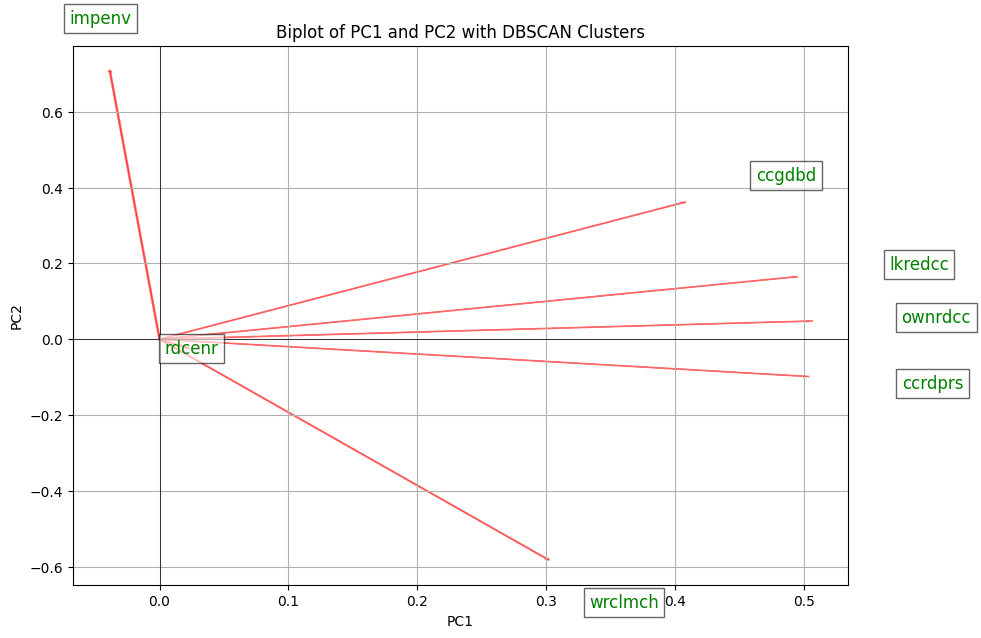

Clusters based on DBSCAN:
              PC1       PC2  Cluster
rdcenr   0.020594 -0.021234        0
ccrdprs  0.499874 -0.097483        1
wrclmch  0.300415 -0.578647        2
ccgdbd   0.405236  0.359416        1
lkredcc  0.491232  0.163814        1
ownrdcc  0.502446  0.047695        1
impenv  -0.038418  0.704928        3
Cronbach's Alpha for Cluster 0: Not enough variables to calculate alpha
Cronbach's Alpha for Cluster 1: 0.7364507641093989 with variables ['ccrdprs', 'ccgdbd', 'lkredcc', 'ownrdcc']
Cronbach's Alpha for Cluster 2: Not enough variables to calculate alpha
Cronbach's Alpha for Cluster 3: Not enough variables to calculate alpha
Cluster Alphas: {1: 0.7364507641093989}


In [70]:

# Define the relevant variables
climate_change_vars3 = [ 'rdcenr','ccrdprs', 'wrclmch', 'ccgdbd', 'lkredcc', 'ownrdcc', 'impenv']

# Ensure you have the climate_change_data with appropriate preprocessing
# Creating a specific DataFrame for Climate Change
climate_change_data = netherlands_df[climate_change_vars3].copy()

# Preprocess the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(climate_change_data)

# Perform PCA
pca = PCA(n_components=2)  # You can adjust the number of components based on your needs
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame to display principal components more clearly
principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(2)])

# Loadings of the variables on each principal component
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(2)], index=climate_change_data.columns)

# Print explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", sum(pca.explained_variance_ratio_))

# Apply DBSCAN clustering on loadings
dbscan = DBSCAN(eps=0.3, min_samples=1)
cluster_labels = dbscan.fit_predict(loadings)

# Plot the biplot with DBSCAN clusters
plt.figure(figsize=(10, 7))
origin = [0, 0]  # origin point

# Plot loadings with cluster labels
for i, (comp1, comp2) in enumerate(loadings.values):
    plt.arrow(origin[0], origin[1], comp1, comp2, color='r', alpha=0.5)
    plt.text(comp1*1.2, comp2*1.2, climate_change_data.columns[i], 
             color='g', ha='center', va='center', fontsize=12, 
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot of PC1 and PC2 with DBSCAN Clusters')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

# Create a DataFrame for cluster labels
loadings['Cluster'] = cluster_labels
print("Clusters based on DBSCAN:")
print(loadings)

# Calculate Cronbach's Alpha for each cluster
def cronbach_alpha(df):
    item_variances = df.var(axis=0, ddof=1)
    total_variance = df.sum(axis=1).var(ddof=1)
    n_items = len(df.columns)
    return (n_items / (n_items - 1)) * (1 - item_variances.sum() / total_variance)

cluster_alphas = {}
for cluster in np.unique(cluster_labels):
    cluster_vars = loadings[loadings['Cluster'] == cluster].index.tolist()
    if len(cluster_vars) > 1:
        alpha = cronbach_alpha(climate_change_data[cluster_vars].dropna())
        cluster_alphas[cluster] = alpha
        print(f"Cronbach's Alpha for Cluster {cluster}: {alpha} with variables {cluster_vars}")
    else:
        print(f"Cronbach's Alpha for Cluster {cluster}: Not enough variables to calculate alpha")

print("Cluster Alphas:", cluster_alphas)


wrmclmch - how worried about climate change

lklmten- how likely large numbers of people limit energy use

ownrdcc - how likely limiting own energy use reduce climate change

impenv - important to care for nature and environment


Explained variance ratio: [0.42595091 0.29966404]
Total explained variance by the first two components: 0.7256149439527009


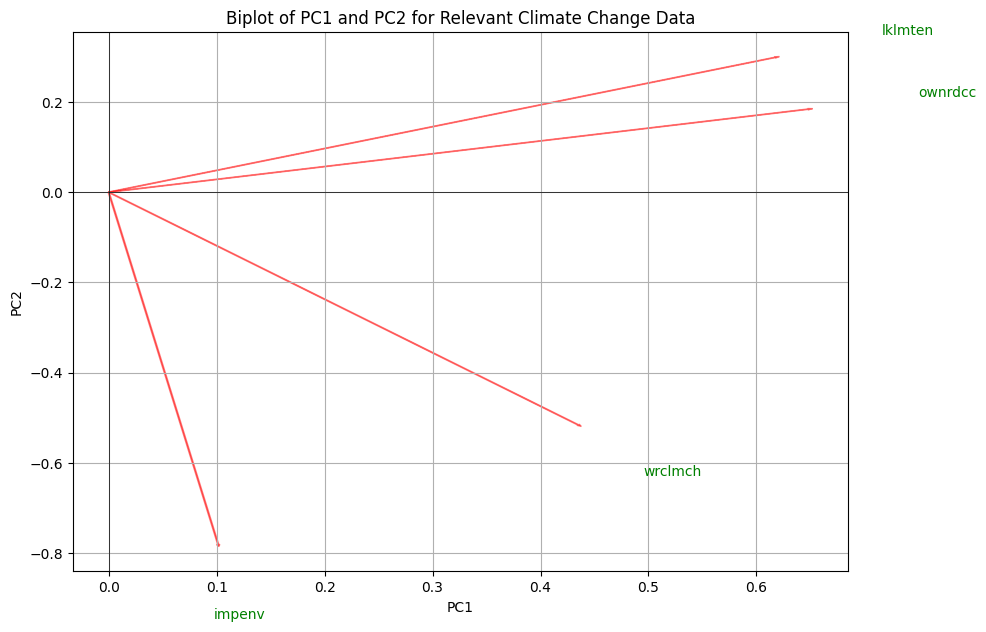

/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_99024/2956007120.py:69: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  high_loading_vars.fillna("", inplace=True)  # Fill NaN values with empty string for better visualization



Variables with high loadings on PC1 and PC2:
               PC1       PC2
impenv            -0.781352
lklmten  0.617195          
ownrdcc  0.647774          
wrclmch   0.43493 -0.516017


Processing combinations: 100%|██████████| 11/11 [00:00<00:00, 245.84it/s]

Combination: ('lklmten', 'ownrdcc'), Cronbach's Alpha: 0.7153323237954381

Variable Frequency in High Alpha Combinations:
lklmten: 1
ownrdcc: 1


In [58]:


# Function to preprocess the data
def preprocess_data(df, column, reverse_scale, max_value):
    if reverse_scale:
        df[column] = (max_value + 1) - df[column]
    df[column] /= max_value

# Function to calculate Cronbach's Alpha
def cronbach_alpha(df):
    item_variances = df.var(axis=0, ddof=1)
    total_variance = df.sum(axis=1).var(ddof=1)
    n_items = len(df.columns)
    return (n_items / (n_items - 1)) * (1 - item_variances.sum() / total_variance)

# Define the relevant variables
relevant_vars = ['wrclmch', 'lklmten', 'ownrdcc', 'impenv']

# Creating a specific DataFrame for the relevant variables
relevant_data = netherlands_df[relevant_vars].copy()

# Preprocess the data
for column in relevant_vars:
    preprocess_data(relevant_data, column, reverse_scale_dict[column], max_value_dict[column])

# Perform PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(relevant_data)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame to display principal components more clearly
principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(2)])

# Loadings of the variables on each principal component
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(2)], index=relevant_data.columns)

explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance)
print("Total explained variance by the first two components:", sum(explained_variance))

# Creating a biplot
plt.figure(figsize=(10, 7))
origin = [0, 0]  # origin point

# Plot loadings
for i, (comp1, comp2) in enumerate(loadings.values):
    plt.arrow(origin[0], origin[1], comp1, comp2, color='r', alpha=0.5)
    plt.text(comp1*1.2, comp2*1.2, relevant_data.columns[i], color='g', ha='center', va='center')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot of PC1 and PC2 for Relevant Climate Change Data')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

# High loading variables
high_loading_vars_pc1 = loadings.index[loadings['PC1'].abs() >= 0.4].tolist()
high_loading_vars_pc2 = loadings.index[loadings['PC2'].abs() >= 0.4].tolist()

selected_vars_pc1 = loadings[loadings['PC1'].abs() >= 0.4][['PC1']].copy()
selected_vars_pc2 = loadings[loadings['PC2'].abs() >= 0.4][['PC2']].copy()

# Merge the two DataFrames for better visualization
high_loading_vars = selected_vars_pc1.merge(selected_vars_pc2, how='outer', left_index=True, right_index=True)

# Display the table
high_loading_vars.fillna("", inplace=True)  # Fill NaN values with empty string for better visualization
print("\nVariables with high loadings on PC1 and PC2:\n", high_loading_vars)

# Find combinations within the relevant variables
valid_combinations = []

# Calculate total number of combinations for progress bar
total_combinations = sum(1 for size in range(2, len(relevant_vars) + 1) for _ in itertools.combinations(relevant_vars, size))

# Check combinations of different sizes within the relevant variables
with tqdm(total=total_combinations, desc="Processing combinations") as pbar:
    for size in range(2, len(relevant_vars) + 1):
        for combination in itertools.combinations(relevant_vars, size):
            subset = relevant_data[list(combination)].dropna()
            alpha = cronbach_alpha(subset)
            if alpha > 0.7:
                valid_combinations.append((combination, alpha))
            pbar.update(1)

# Sort combinations by Cronbach's Alpha in descending order
valid_combinations.sort(key=lambda x: x[1], reverse=True)

# Print the valid combinations
for combination, alpha in valid_combinations:
    print(f"Combination: {combination}, Cronbach's Alpha: {alpha}")

# Frequency count of variables in valid combinations
variable_frequency = {}
for combination, alpha in valid_combinations:
    for variable in combination:
        if variable in variable_frequency:
            variable_frequency[variable] += 1
        else:
            variable_frequency[variable] = 1

# Sort variables by frequency
sorted_variables = sorted(variable_frequency.items(), key=lambda x: x[1], reverse=True)

print("\nVariable Frequency in High Alpha Combinations:")
for variable, frequency in sorted_variables:
    print(f"{variable}: {frequency}")


Explained variance ratio: [0.42595091 0.29966404]
Total explained variance by the first two components: 0.7256149439527012

Variables with high loadings on PC1 and PC2:
               PC1       PC2
impenv            -0.781352
lklmten  0.617195          
ownrdcc  0.647774          
wrclmch   0.43493 -0.516017


/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_99024/66776621.py:69: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  high_loading_vars.fillna("", inplace=True)  # Fill NaN values with empty string for better visualization


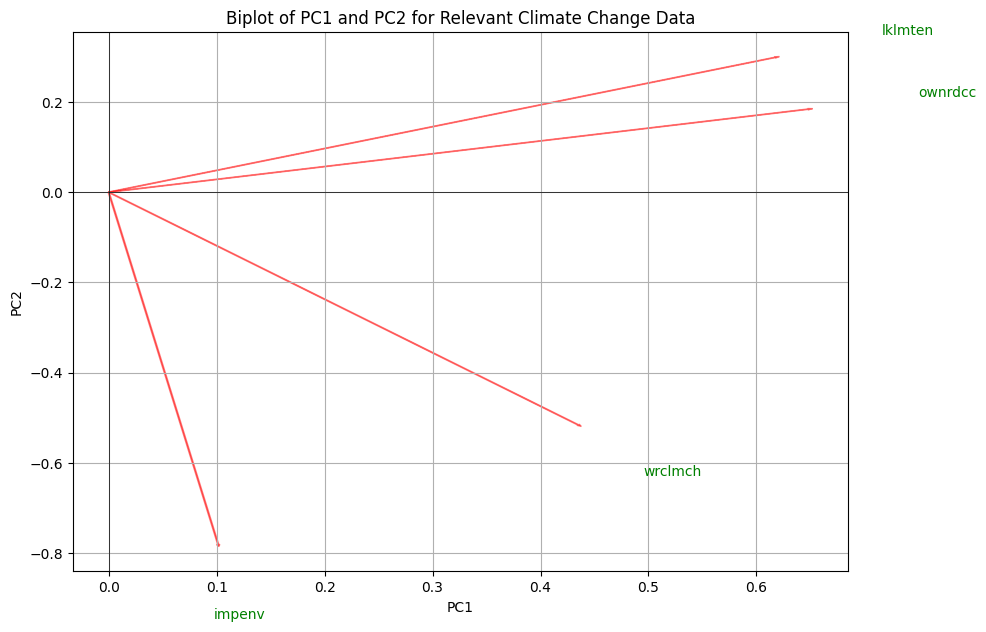

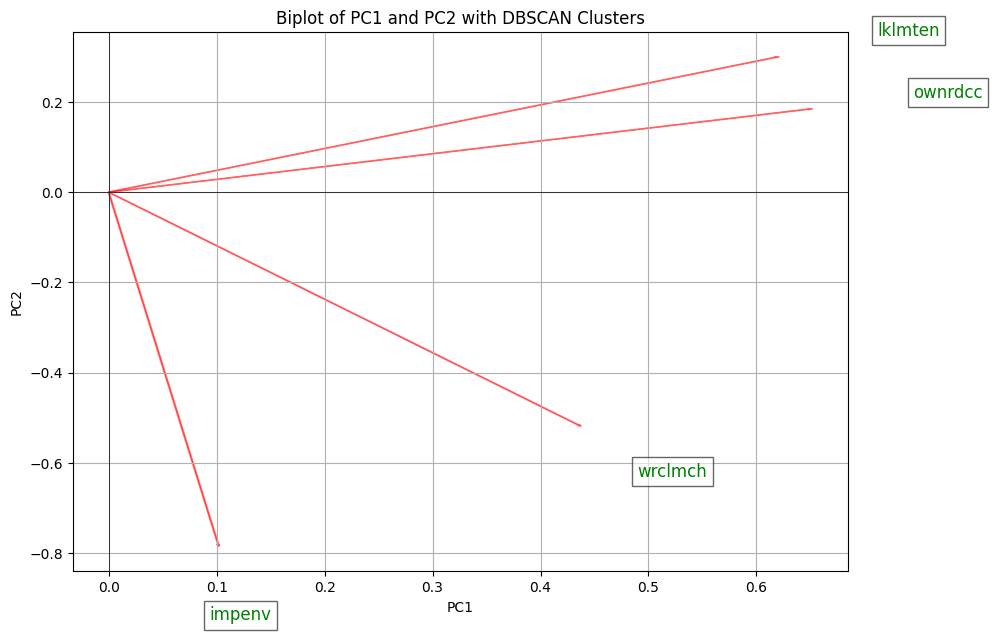

Clusters based on DBSCAN:
              PC1       PC2  Cluster
wrclmch  0.434930 -0.516017       -1
lklmten  0.617195  0.298875        0
ownrdcc  0.647774  0.184091        0
impenv   0.101468 -0.781352       -1
Cronbach's Alpha for Cluster -1: 0.4142190748909955 with variables ['wrclmch', 'impenv']
Cronbach's Alpha for Cluster 0: 0.7153323237954381 with variables ['lklmten', 'ownrdcc']


In [66]:


# Function to preprocess the data
def preprocess_data(df, column, reverse_scale, max_value):
    if reverse_scale:
        df[column] = (max_value + 1) - df[column]
    df[column] /= max_value

# Function to calculate Cronbach's Alpha
def cronbach_alpha(df):
    item_variances = df.var(axis=0, ddof=1)
    total_variance = df.sum(axis=1).var(ddof=1)
    n_items = len(df.columns)
    return (n_items / (n_items - 1)) * (1 - item_variances.sum() / total_variance)

# Define the relevant variables
relevant_vars = ['wrclmch', 'lklmten', 'ownrdcc', 'impenv']

# Creating a specific DataFrame for the relevant variables
climate_change_data = netherlands_df[relevant_vars].copy()

# Preprocess the data
for column in relevant_vars:
    preprocess_data(climate_change_data, column, reverse_scale_dict[column], max_value_dict[column])

# Perform PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(climate_change_data)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame to display principal components more clearly
principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(2)])

# Loadings of the variables on each principal component
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(2)], index=climate_change_data.columns)

explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance)
print("Total explained variance by the first two components:", sum(explained_variance))

# Creating a biplot
plt.figure(figsize=(10, 7))
origin = [0, 0]  # origin point

# Plot loadings
for i, (comp1, comp2) in enumerate(loadings.values):
    plt.arrow(origin[0], origin[1], comp1, comp2, color='r', alpha=0.5)
    plt.text(comp1*1.2, comp2*1.2, climate_change_data.columns[i], color='g', ha='center', va='center')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot of PC1 and PC2 for Relevant Climate Change Data')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
#plt.show()

# High loading variables
high_loading_vars_pc1 = loadings.index[loadings['PC1'].abs() >= 0.4].tolist()
high_loading_vars_pc2 = loadings.index[loadings['PC2'].abs() >= 0.4].tolist()

selected_vars_pc1 = loadings[loadings['PC1'].abs() >= 0.4][['PC1']].copy()
selected_vars_pc2 = loadings[loadings['PC2'].abs() >= 0.4][['PC2']].copy()

# Merge the two DataFrames for better visualization
high_loading_vars = selected_vars_pc1.merge(selected_vars_pc2, how='outer', left_index=True, right_index=True)

# Display the table
high_loading_vars.fillna("", inplace=True)  # Fill NaN values with empty string for better visualization
print("\nVariables with high loadings on PC1 and PC2:\n", high_loading_vars)

# Apply DBSCAN clustering on loadings
dbscan = DBSCAN(eps=0.3, min_samples=2)
cluster_labels = dbscan.fit_predict(loadings)

# Plot the biplot with DBSCAN clusters
plt.figure(figsize=(10, 7))
origin = [0, 0]  # origin point

# Plot loadings with cluster labels
for i, (comp1, comp2) in enumerate(loadings.values):
    plt.arrow(origin[0], origin[1], comp1, comp2, color='r', alpha=0.5)
    plt.text(comp1*1.2, comp2*1.2, climate_change_data.columns[i], 
             color='g', ha='center', va='center', fontsize=12, 
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot of PC1 and PC2 with DBSCAN Clusters')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

# Create a DataFrame for cluster labels
loadings['Cluster'] = cluster_labels
print("Clusters based on DBSCAN:")
print(loadings)

# Calculate Cronbach's Alpha for each cluster
cluster_alphas = {}
for cluster in np.unique(cluster_labels):
    cluster_vars = loadings[loadings['Cluster'] == cluster].index.tolist()
    if len(cluster_vars) > 1:
        alpha = cronbach_alpha(climate_change_data[cluster_vars].dropna())
        cluster_alphas[cluster] = alpha
        print(f"Cronbach's Alpha for Cluster {cluster}: {alpha} with variables {cluster_vars}")
    else:
        print(f"Cronbach's Alpha for Cluster {cluster}: Not enough variables to calculate alpha")





Preference Variables:

These reflect an individual's attitudes, values, or inclinations towards sustainability and environmental issues.

wrmclmch - How worried about climate change
Reason: This variable captures an individual's concern about climate change, which reflects their personal values and attitudes towards the environment.

impenv - Important to care for nature and environment
Reason: This variable directly measures the importance an individual places on caring for the environment, which is a reflection of their personal values and preferences.

Weight Variables:

These reflect the practical influence or importance placed on these preferences when making decisions, especially considering factors such as societal influence.

lklmten - How likely large numbers of people limit energy use
Reason: This variable captures an individual's perception of societal action towards energy use reduction, indicating how much they consider societal behavior in their decision-making process.

ownrdcc - How likely limiting own energy use reduce climate change
Reason: This variable reflects an individual's belief in the impact of their own actions on climate change, indicating how much they weigh their environmental preferences in their personal actions.

## All Social Data

Links to conformity, how much your social network impacts you

'ppltrst', 'pplfair', 'pplhlp','sclmeet','inprdsc', 'sclact', 'ipbhprp','ipfrule','iplylfr'

ppltrst - Most people can be trusted or you can't be too careful.
This variable measures general trust in people, which can reflect the degree to which someone conforms to a generally trusting or mistrustful societal norm. ALL

pplfair - Most people try to take advantage of you, or try to be fair.
Reflects perceptions of fairness in others, which can influence and be influenced by social norms and interactions.ALL

pplhlp - Most of the time people are helpful or mostly looking out for themselves.
Indicates perceptions of altruism or self-interest in others, potentially shaped by the social environment. ALL

sclmeet - How often socially meet with friends, relatives or colleagues.
Directly related to social interaction frequency, reflecting how integrated a person is within their social network. ALL

inprdsc - How many people with whom you can discuss intimate and personal matters.
Measures the closeness and extent of an individual's social support network, indicative of social integration and potential conformity to social norms. ALL

sclact - Take part in social activities compared to others of the same age.
Assesses engagement in social activities, which can be influenced by peer behavior and societal expectations. ALL

ipbhprp - Important to behave properly.
Reflects the importance placed on adhering to socially accepted norms and behaviors. ALL

ipfrule - Important to do what is told and follow rules.
Highlights the value placed on obedience and conformity to established rules, which is often a reflection of societal influence. ALL

iplylfr - Important to be loyal to friends and devote to people close.
Indicates the value placed on loyalty within one's social network, which can be a form of social conformity.ALL

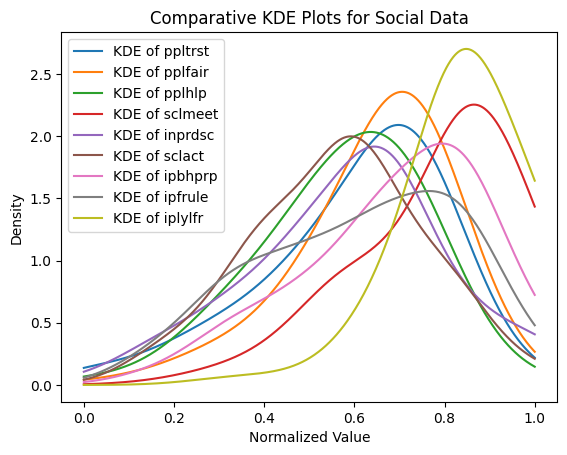

Cronbach's Alpha: 0.4936930129954461


In [77]:
# Define the variables for each category
social_vars = ['ppltrst','pplfair','pplhlp','sclmeet', 'inprdsc','sclact','ipbhprp','ipfrule','iplylfr']

# Creating a specific DataFrame for Climate Change
social_data = netherlands_df[social_vars].copy()


valid_range_dict = {
    'ppltrst': range(0, 11),
    'pplfair': range(0, 11),
    'pplhlp': range(0, 11),
    'sclmeet': range(1, 8),
    'inprdsc': range(0, 7),
    'sclact': range(1, 6),
    'ipbhprp': range(1, 7),
    'ipfrule': range(1, 7),
    'iplylfr': range(1, 7)
}

reverse_scale_dict = {
    'ppltrst': False,  # Higher values indicate more trust, no need to reverse.
    'pplfair': False,  # Higher values indicate seeing people as fairer, no need to reverse.
    'pplhlp': False,   # Higher values indicate seeing people as more helpful, no need to reverse.
    'sclmeet': False,  # Higher values already indicate more frequent social meetings.
    'inprdsc': False,  # Higher values indicate more intimate connections.
    'sclact': False,   # Higher values already mean more social activity.
    'ipbhprp': True,   # Lower values indicate it is more like them; reverse to align.
    'ipfrule': True,   # Lower values indicate more rule-following; reverse to align.
    'iplylfr': True    # Lower values indicate more loyalty; reverse to align.
}

max_value_dict = {
    'ppltrst': 10,
    'pplfair': 10,
    'pplhlp': 10,
    'sclmeet': 7,
    'inprdsc': 6, 
    'sclact': 5,
    'ipbhprp': 6,
    'ipfrule': 6,
    'iplylfr': 6
}

# Preprocessing data
for column in social_vars:
    original_count = social_data.shape[0]
    social_data = social_data[social_data[column].isin(valid_range_dict[column])]
    filtered_count = social_data.shape[0]
    #print(f"{column}: Reduced from {original_count} to {filtered_count}")
    preprocess_data(social_data, column, reverse_scale_dict[column], max_value_dict[column])


# Plotting KDE for each variable
for column in social_vars:
    simplified_kde_plot(column, social_data)

plt.title('Comparative KDE Plots for Social Data')
plt.xlabel('Normalized Value')
plt.ylabel('Density')
plt.legend()
plt.show()

# Calculate and print Cronbach's Alpha
alpha = cronbach_alpha(social_data)  # Ensure no NaNs before calculating
print(f"Cronbach's Alpha: {alpha}")

/Users/isabelklennert/opt/anaconda3/envs/thesisenv/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/isabelklennert/opt/anaconda3/envs/thesisenv/lib/python3.9/site-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


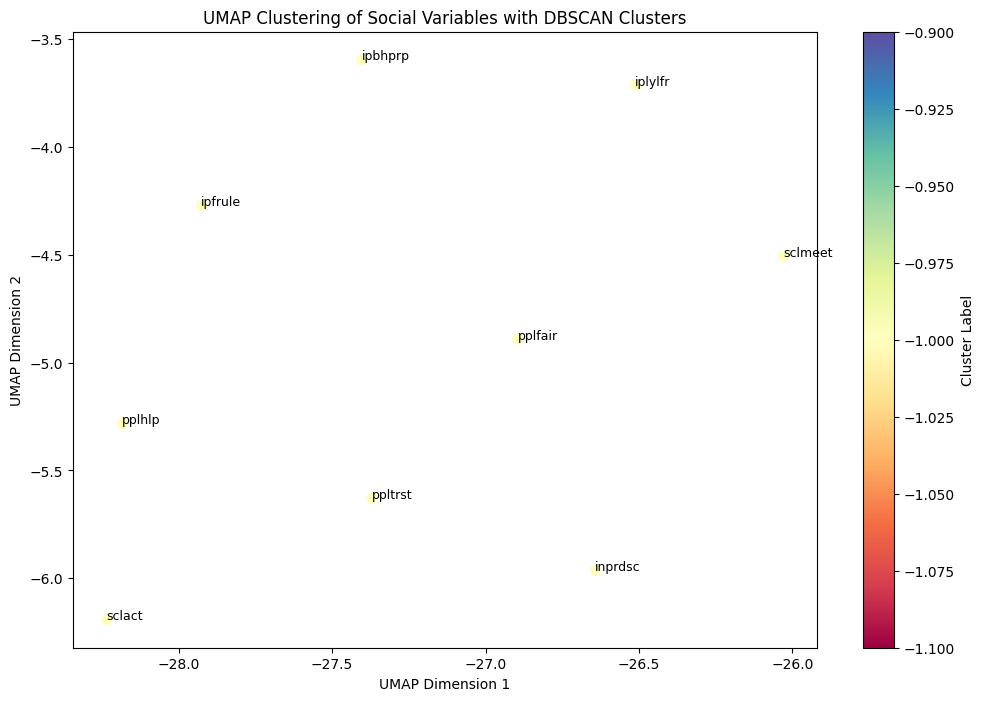

Cluster -1: ['ppltrst', 'pplfair', 'pplhlp', 'sclmeet', 'inprdsc', 'sclact', 'ipbhprp', 'ipfrule', 'iplylfr']
Cronbach's Alpha for Cluster -1: 0.4936930129954461


In [72]:
# Preprocess the data for UMAP
data_to_scale = social_data.dropna(axis=1).transpose()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Define the function to perform UMAP clustering
def umap_clustering(scaled_data, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', random_state=42):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric=metric, random_state=random_state)
    embedding = reducer.fit_transform(scaled_data)
    return embedding

# Visualize UMAP Clusters
def plot_umap(embedding, data, title='UMAP Clustering of Social Variables'):
    plt.figure(figsize=(12, 8))
    plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=50)
    
    for i, var in enumerate(data.index):
        plt.text(embedding[i, 0], embedding[i, 1], var, fontsize=9)
    
    plt.title(title)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.show()

# Apply UMAP Clustering with fixed random seed
embedding = umap_clustering(scaled_data, n_neighbors=20, min_dist=0.2, metric='cosine', random_state=42)


# Apply DBSCAN to find clusters on the variable embeddings
clustering = DBSCAN(eps=0.7, min_samples=2).fit(embedding)  # Adjusted parameters

# Add cluster labels to the variable embeddings
cluster_labels = clustering.labels_

# Plot UMAP Clusters with DBSCAN clusters
plt.figure(figsize=(12, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='Spectral', s=50)
for i, var in enumerate(data_to_scale.index):
    plt.text(embedding[i, 0], embedding[i, 1], var, fontsize=9)
plt.title('UMAP Clustering of Social Variables with DBSCAN Clusters')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Print cluster members
clusters = {}
for cluster in set(cluster_labels):
    clusters[cluster] = data_to_scale.index[cluster_labels == cluster].tolist()
    print(f"Cluster {cluster}: {clusters[cluster]}")

# Calculate and print Cronbach's Alpha for each cluster
for cluster, variables in clusters.items():
    if variables:
        alpha = cronbach_alpha(social_data[variables].dropna())
        print(f"Cronbach's Alpha for Cluster {cluster}: {alpha}")

### Correlation matrix

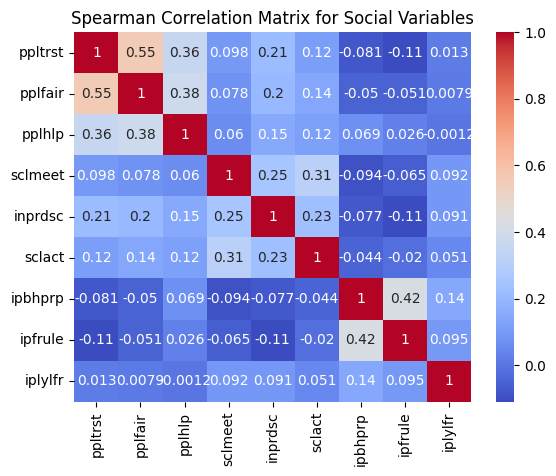

In [59]:
import seaborn as sns

# Correlation matrix
corr_matrix = social_data.corr(method='spearman')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Spearman Correlation Matrix for Social Variables')
plt.show()

### PCA

Explained variance ratio: [0.24438763 0.16456875]
Total explained variance by the first two components: 0.4089563755455011


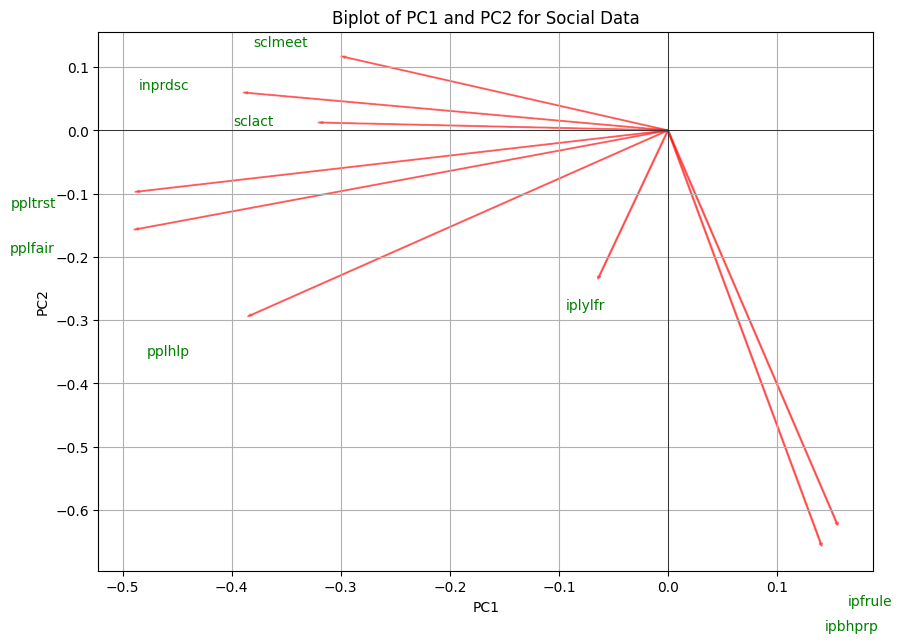


Variables with high loadings on PC1 and PC2:
               PC1       PC2
ipbhprp           -0.652978
ipfrule           -0.620217
pplfair -0.485557          
ppltrst -0.484526          


/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_99024/4265677147.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  high_loading_vars.fillna("", inplace=True)  # Fill NaN values with empty string for better visualization


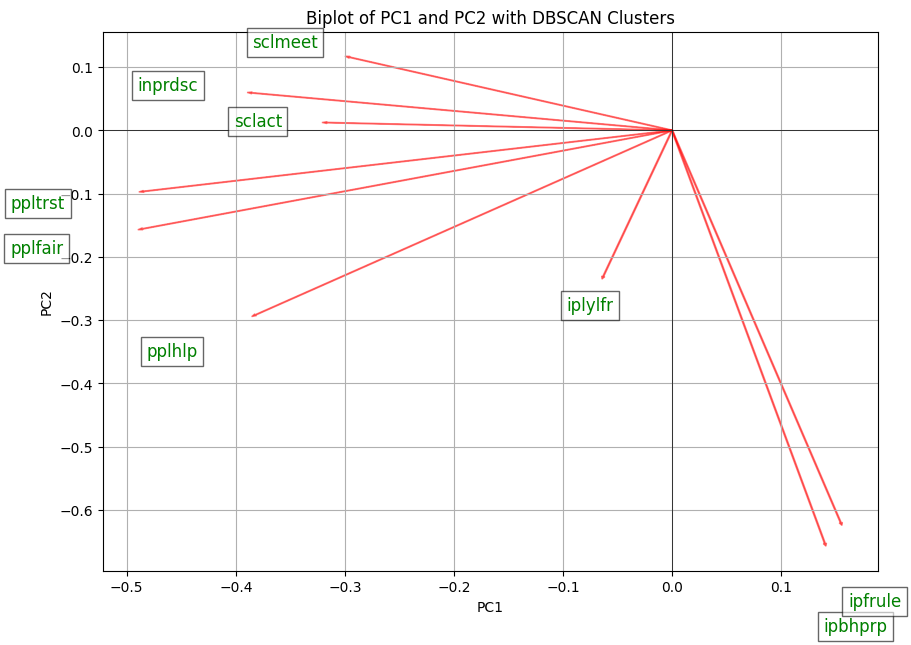

Clusters based on DBSCAN:
              PC1       PC2  Cluster
ppltrst -0.484526 -0.096488        0
pplfair -0.485557 -0.155727        0
pplhlp  -0.381906 -0.291680        0
sclmeet -0.295803  0.115646        0
inprdsc -0.385221  0.059260        0
sclact  -0.316539  0.012273        0
ipbhprp  0.140094 -0.652978        1
ipfrule  0.154655 -0.620217        1
iplylfr -0.063081 -0.230815        2
Cronbach's Alpha for Cluster 0: 0.6310425685246426 with variables ['ppltrst', 'pplfair', 'pplhlp', 'sclmeet', 'inprdsc', 'sclact']
Cronbach's Alpha for Cluster 1: 0.5961414100030527 with variables ['ipbhprp', 'ipfrule']
Cronbach's Alpha for Cluster 2: Not enough variables to calculate alpha


In [87]:


# Preprocess the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(social_data)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame to display principal components more clearly
principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(2)])

# Loadings of the variables on each principal component
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(2)], index=social_data.columns)

explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance)
print("Total explained variance by the first two components:", sum(explained_variance))

# Creating a biplot
plt.figure(figsize=(10, 7))
origin = [0, 0]  # origin point

# Plot loadings
for i, (comp1, comp2) in enumerate(loadings.values):
    plt.arrow(origin[0], origin[1], comp1, comp2, color='r', alpha=0.5)
    plt.text(comp1*1.2, comp2*1.2, social_data.columns[i], color='g', ha='center', va='center')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot of PC1 and PC2 for Social Data')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

# High loading variables
high_loading_vars_pc1 = loadings.index[loadings['PC1'].abs() >= 0.4].tolist()
high_loading_vars_pc2 = loadings.index[loadings['PC2'].abs() >= 0.4].tolist()

selected_vars_pc1 = loadings[loadings['PC1'].abs() >= 0.4][['PC1']].copy()
selected_vars_pc2 = loadings[loadings['PC2'].abs() >= 0.4][['PC2']].copy()

# Merge the two DataFrames for better visualization
high_loading_vars = selected_vars_pc1.merge(selected_vars_pc2, how='outer', left_index=True, right_index=True)

# Display the table
high_loading_vars.fillna("", inplace=True)  # Fill NaN values with empty string for better visualization
print("\nVariables with high loadings on PC1 and PC2:\n", high_loading_vars)

# Apply DBSCAN clustering on loadings
dbscan = DBSCAN(eps=0.3, min_samples=1)
cluster_labels = dbscan.fit_predict(loadings)

# Add cluster labels to loadings DataFrame
loadings['Cluster'] = cluster_labels

# Plot the biplot with DBSCAN clusters
plt.figure(figsize=(10, 7))
origin = [0, 0]  # origin point

# Plot loadings with cluster labels
for i, (comp1, comp2) in enumerate(loadings.iloc[:, :2].values):
    plt.arrow(origin[0], origin[1], comp1, comp2, color='r', alpha=0.5)
    plt.text(comp1*1.2, comp2*1.2, social_data.columns[i], 
             color='g', ha='center', va='center', fontsize=12, 
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot of PC1 and PC2 with DBSCAN Clusters')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

# Create a DataFrame for cluster labels
print("Clusters based on DBSCAN:")
print(loadings)

# Calculate Cronbach's Alpha for each cluster
def cronbach_alpha(df):
    item_variances = df.var(axis=0, ddof=1)
    total_variance = df.sum(axis=1).var(ddof=1)
    n_items = len(df.columns)
    return (n_items / (n_items - 1)) * (1 - item_variances.sum() / total_variance)

cluster_alphas = {}
for cluster in np.unique(cluster_labels):
    cluster_vars = loadings[loadings['Cluster'] == cluster].index.tolist()
    if len(cluster_vars) > 1:
        alpha = cronbach_alpha(social_data[cluster_vars].dropna())
        cluster_alphas[cluster] = alpha
        print(f"Cronbach's Alpha for Cluster {cluster}: {alpha} with variables {cluster_vars}")
    else:
        print(f"Cronbach's Alpha for Cluster {cluster}: Not enough variables to calculate alpha")


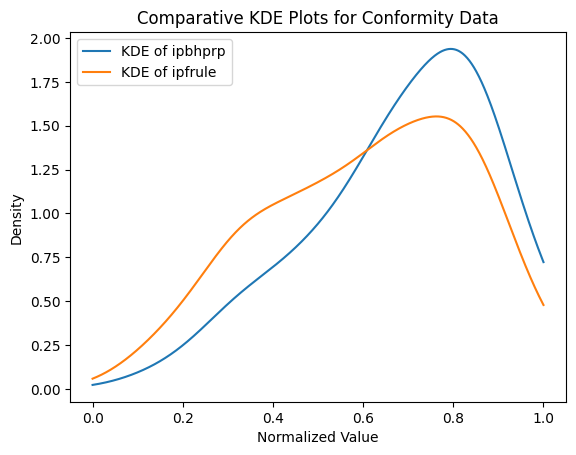

Cronbach's Alpha: 0.705398934908237


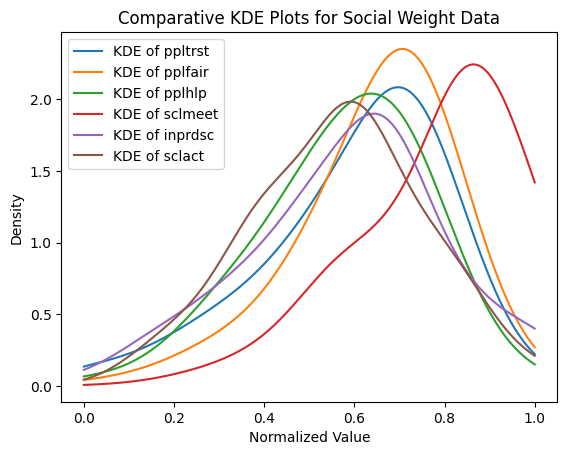

Cronbach's Alpha: 0.6406113994257987


In [61]:

# Define the variables for each attribute category
conformity_vars = ['ipbhprp', 'ipfrule']
social_weight_vars = ['ppltrst', 'pplfair', 'pplhlp', 'sclmeet', 'inprdsc', 'sclact']

# Initialize the DataFrame for conformity and social weight
conformity_data =  netherlands_df[conformity_vars].copy()
social_weight_data =  netherlands_df[social_weight_vars].copy()


conformity_vars_valid_range_dict = {
    'ipbhprp': range(1, 7),
    'ipfrule': range(1, 7),
    #'iplylfr': range(1, 7)
}


social_weight_vars_valid_range_dict = {
    'ppltrst': range(0, 11),
    'pplfair': range(0, 11),
    'pplhlp': range(0, 11),
    'sclmeet': range(1, 8),
    'inprdsc': range(0, 7),
    'sclact': range(1, 6)
}

conformity_vars_reverse_scale_dict = {
    'ipbhprp': True,   # Lower values indicate it is more like them; reverse to align.
    'ipfrule': True,   # Lower values indicate more rule-following; reverse to align.
    #'iplylfr': True    # Lower values indicate more loyalty; reverse to align.
}

social_weight_vars_reverse_scale_dict = {
    'ppltrst': False,  # Higher values indicate more trust, no need to reverse.
    'pplfair': False,  # Higher values indicate seeing people as fairer, no need to reverse.
    'pplhlp': False,   # Higher values indicate seeing people as more helpful, no need to reverse.
    'sclmeet': False,  # Higher values already indicate more frequent social meetings.
    'inprdsc': False,  # Higher values indicate more intimate connections.
    'sclact': False   # Higher values already mean more social activity
}

conformity_vars_max_value_dict = {
    'ipbhprp': 6,
    'ipfrule': 6,
    'iplylfr': 6
}

social_weight_vars_max_value_dict = {
    'ppltrst': 10,
    'pplfair': 10,
    'pplhlp': 10,
    'sclmeet': 7,
    'inprdsc': 6, 
    'sclact': 5
}

def preprocess_data(df, column, reverse, max_val):
    # Filter data
    valid_data = df[column].isin(valid_range_dict[column])
    
    # Reverse scale if necessary
    if reverse:
        df[column] = (max_val + 1) - df[column]
    
    # Normalize the data
    df[column] = df[column] / max_val
    
    return df[column][valid_data]  # Only return valid data without modifying DataFrame

# Now let's preprocess each group of variables and assign the returned series back to the DataFrame
for column in conformity_vars:
    conformity_data[column] = preprocess_data(conformity_data, column, 
                                              conformity_vars_reverse_scale_dict[column], 
                                              conformity_vars_max_value_dict[column])

for column in social_weight_vars:
    social_weight_data[column] = preprocess_data(social_weight_data, column, 
                                                 social_weight_vars_reverse_scale_dict[column], 
                                                 social_weight_vars_max_value_dict[column])


# Plotting KDE for each variable
for column in conformity_vars:
    simplified_kde_plot(column, conformity_data)

plt.title('Comparative KDE Plots for Conformity Data')
plt.xlabel('Normalized Value')
plt.ylabel('Density')
plt.legend()
plt.show()

# Calculate and print Cronbach's Alpha
alpha = cronbach_alpha(conformity_data) 
print(f"Cronbach's Alpha: {alpha}")

# Plotting KDE for each variable
for column in social_weight_vars:
    simplified_kde_plot(column, social_weight_data)

plt.title('Comparative KDE Plots for Social Weight Data')
plt.xlabel('Normalized Value')
plt.ylabel('Density')
plt.legend()
plt.show()

# Calculate and print Cronbach's Alpha
alpha = cronbach_alpha(social_weight_data) 
print(f"Cronbach's Alpha: {alpha}")


In [62]:
import pandas as pd
import numpy as np
import itertools
from sklearn.preprocessing import StandardScaler

# Define the social weight variables
social_weight_vars = ['ppltrst', 'pplfair', 'pplhlp', 'sclmeet', 'inprdsc', 'sclact']
social_weight_data = netherlands_df[social_weight_vars].copy()

valid_range_dict = {
    'ppltrst': range(0, 11),
    'pplfair': range(0, 11),
    'pplhlp': range(0, 11),
    'sclmeet': range(1, 8),
    'inprdsc': range(0, 7),
    'sclact': range(1, 6)
}

reverse_scale_dict = {
    'ppltrst': False,
    'pplfair': False,
    'pplhlp': False,
    'sclmeet': False,
    'inprdsc': False,
    'sclact': False
}

max_value_dict = {
    'ppltrst': 10,
    'pplfair': 10,
    'pplhlp': 10,
    'sclmeet': 7,
    'inprdsc': 6,
    'sclact': 5
}

# Function to preprocess data
def preprocess_data(df, column, reverse_scale, max_value):
    if reverse_scale:
        df[column] = (max_value + 1) - df[column]
    df[column] /= max_value

# Preprocess the social weight data
for column in social_weight_vars:
    social_weight_data = social_weight_data[social_weight_data[column].isin(valid_range_dict[column])]
    preprocess_data(social_weight_data, column, reverse_scale_dict[column], max_value_dict[column])

# Calculate Cronbach's Alpha
def cronbach_alpha(df):
    item_variances = df.var(axis=0, ddof=1)
    total_variance = df.sum(axis=1).var(ddof=1)
    n_items = len(df.columns)
    return (n_items / (n_items - 1)) * (1 - item_variances.sum() / total_variance)

# Find the best combination of variables
best_alpha = 0
best_combination = []

for size in [2, 6]:
    for combination in itertools.combinations(social_weight_vars, size):
        subset = social_weight_data[list(combination)].dropna()
        alpha = cronbach_alpha(subset)
        if alpha > best_alpha:
            best_alpha = alpha
            best_combination = combination

print(f"Best combination of variables: {best_combination}")
print(f"Cronbach's Alpha for the best combination: {best_alpha}")


Best combination of variables: ('ppltrst', 'pplfair')
Cronbach's Alpha for the best combination: 0.6962762962841347


## Job stability


icpdwrk - in paid work

wrkctra - employment contract unlimited or limited

hincfel - feeling about household's income nowadays

lkuemp - how likely unemployed and looking for work next 12 month 

lknemny - how likely not enough money for household necessities next 12 months

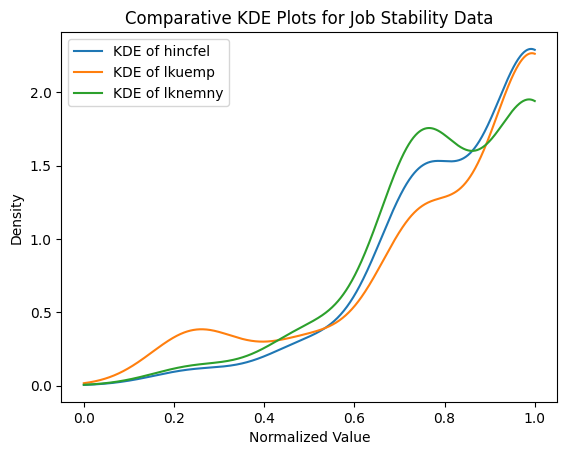

Cronbach's Alpha: 0.6910552619651942


In [104]:
job_stability_vars = [ 'hincfel', 'lkuemp', 'lknemny']
job_stability_data = netherlands_df[job_stability_vars].copy()

# Valid range dictionary based on your understanding of the variables
valid_range_dict = {
    #'icpdwrk': range(1, 3),  # Adjusted to include actual ranges
    #'wrkctra': range(1, 4),
    'hincfel': range(1, 5),
    'lkuemp': range(1, 5),
    'lknemny': range(1, 5)
}

reverse_scale_dict = {
    #'icpdwrk': True,  # 1 for in paid work is positive, no reversal; 2 for not in paid work needs reversal
    #'wrkctra': False, # Unlimited contract (1) is more stable, limited (2) or no contract (3) are less stable
    'hincfel': True,   # Higher numbers indicate more difficulty living on income, so reverse to align with stability
    'lkuemp': True,
    'lknemny': True
}

max_value_dict = {
    #'icpdwrk': 2,  # 1 in work, 2 not in work, thus max is 2
    #'wrkctra': 3,  # Unlimited, limited, no contract
    'hincfel': 4,   # From living comfortably to very difficult
    'lkuemp': 4,
    'lknemny': 4
}

# Preprocessing data
for column in job_stability_vars:
    original_count = job_stability_data.shape[0]
    job_stability_data = job_stability_data[job_stability_data[column].isin(valid_range_dict[column])]
    filtered_count = job_stability_data.shape[0]
    #print(f"{column}: Reduced from {original_count} to {filtered_count}")
    preprocess_data(job_stability_data, column, reverse_scale_dict[column], max_value_dict[column])


# Plotting KDE for each variable
for column in job_stability_vars:
    simplified_kde_plot(column, job_stability_data)

plt.title('Comparative KDE Plots for Job Stability Data')
plt.xlabel('Normalized Value')
plt.ylabel('Density')
plt.legend()
plt.show()

# Calculate and print Cronbach's Alpha
alpha = cronbach_alpha(job_stability_data)  # Ensure no NaNs before calculating
print(f"Cronbach's Alpha: {alpha}")

In [105]:
# Find the best combination of 2 variables
best_alpha = 0
best_combination = []

for combination in itertools.combinations(job_stability_vars, 2):
    subset = job_stability_data[list(combination)].dropna()
    alpha = cronbach_alpha(subset)
    if alpha > best_alpha:
        best_alpha = alpha
        best_combination = combination

print(f"Best combination of 2 variables: {best_combination}")
print(f"Cronbach's Alpha for the best combination: {best_alpha}")

Best combination of 2 variables: ('hincfel', 'lknemny')
Cronbach's Alpha for the best combination: 0.7329639395323944


2024-05-23 15:56:18 DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7f8fbc092460>
locator: <matplotlib.ticker.AutoLocator object at 0x7f8fbc092460>
locator: <matplotlib.ticker.AutoLocator object at 0x7f8fbc092460>
locator: <matplotlib.ticker.AutoLocator object at 0x7f8fbc092460>
locator: <matplotlib.ticker.AutoLocator object at 0x7f8fbc092460>


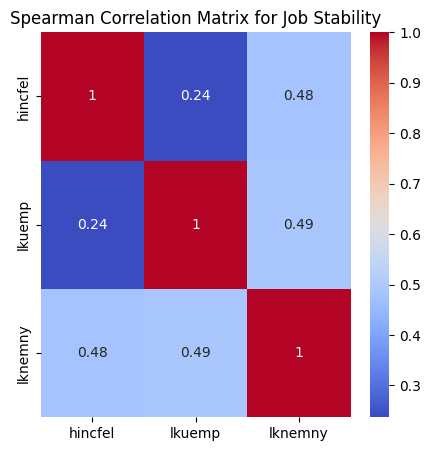

In [106]:
# Correlation matrix
plt.figure(figsize=(5, 5))
corr_matrix = job_stability_data.corr(method='spearman')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Spearman Correlation Matrix for Job Stability')
plt.show()

Explained variance ratio: [0.63366076 0.23796225]
Total explained variance by the first component: 0.6336607646111289


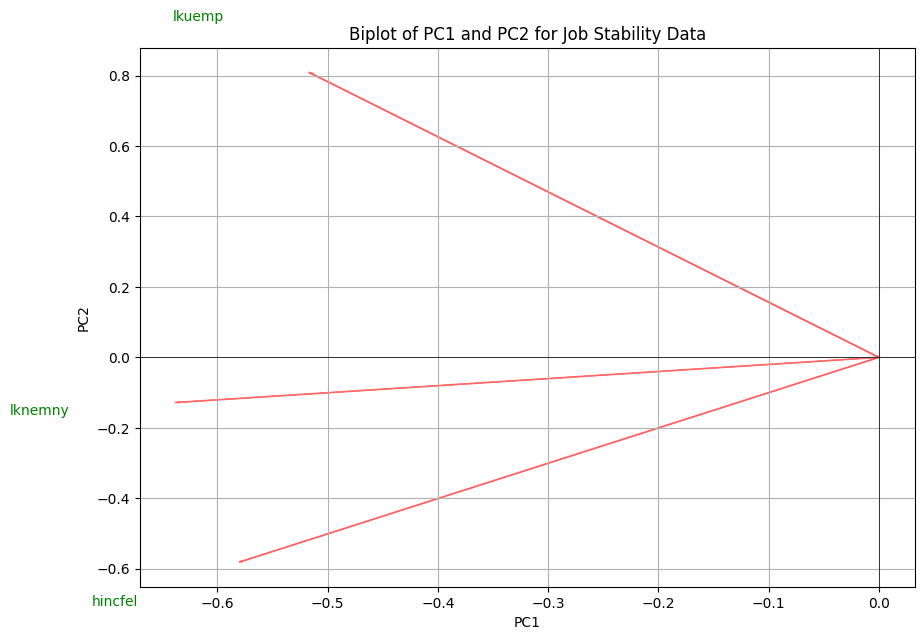

In [107]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(job_stability_data)  

# Applying PCA
pca = PCA(n_components=2)  # Adjust based on the variance you need to capture
principal_components = pca.fit_transform(scaled_data)
# Create a DataFrame to display principal components more clearly
principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(2)])

# Loadings of the variables on each principal component
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(2)], index=job_stability_data.columns)
loadings

explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance)
print("Total explained variance by the first component:", explained_variance[0])

# Creating a biplot
plt.figure(figsize=(10, 7))
origin = [0, 0]  # origin point

# Plot loadings
for i, (comp1, comp2) in enumerate(loadings.values):
    plt.arrow(origin[0], origin[1], comp1, comp2, color='r', alpha=0.5)
    plt.text(comp1*1.2, comp2*1.2, job_stability_data.columns[i], color='g', ha='center', va='center')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot of PC1 and PC2 for Job Stability Data')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

## Weight Financial

'imprich' - Important to be rich, have money and expensive things
